# ASSIGNMENT 5 FOR COMPUTER VISION

José Luis Cano-Manuel Claver and Ana San Román Gaitero

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

import cv2
import numpy as np
import os
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout


# Functions

In [ ]:
def middle_frame(image_files, image_labels, video_data_path):
  
  input_shape = (224, 224, 3)

  images, labels = [], []
  for file_name, label in zip(image_files, image_labels):
      
      folder_path = os.path.join(video_data_path, label)
      
      video_path = os.path.join(folder_path, file_name)
      cap = cv2.VideoCapture(video_path)

      # Get the total number of frames
      total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      middle_frame = int(total_frames / 2)

      cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame)
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      h, w = frame.shape[:2]
      center_x = int(w/2)
      center_y = int(h/2)
      length = min(h, w)
      start_x = center_x - int(length/2)
      start_y = center_y - int(length/2)
      cropped_img = frame[start_y:start_y+length, start_x:start_x+length]
      resized_img = cv2.resize(cropped_img, (224, 224))
      normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

      images.append(normalized)
      labels.append(label)
     
      cap.release()

  images = np.array(images)
  images = images.reshape(-1, input_shape[0], input_shape[1], 3)
  labels = np.array(labels)

  return images, labels

In [ ]:
import math

def train_model(model,train_images, train_labels, validation_images,validation_labels):
  """
  train_model uses a validation and training set for training the correspondant model and
  saves the best model weights into a file
  """

  # Show how the network is generated
  tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

  # compile the model 
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
 
  history = model.fit(train_images, train_labels, epochs=15, validation_data=(validation_images,validation_labels))


  # Plot the training and validation loss values
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def cyclical_learning_rate(epoch, step_size):
    base_lr = 1e-5
    max_lr = 1e-2

    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    print(step_size)
    return new_lr

def train_model_CLR(model, train_images, train_labels, validation_images, validation_labels, model_name, data_augmentation=False):
    # Show how the network is generated
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

    # compile the model 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/' + model_name
  
    if data_augmentation == True:
      step_size = 12
    else:
      step_size = 6

    # define a checkpoint to save the best model weights based on validation accuracy
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    lr_scheduler = LearningRateScheduler(lambda epoch: cyclical_learning_rate(epoch, step_size))

    history = model.fit(train_images, train_labels, batch_size = 64, epochs=25, validation_data=(validation_images,validation_labels), callbacks=[checkpoint, lr_scheduler])

    # Plot the training and validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

def train_model2_CLR(model, train_images, train_labels, validation_images, validation_labels, model_name, data_augmentation = False):
    # Show how the network is generated
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)
    if data_augmentation == True:
      step_size = 16
    else:
      step_size = 8

    # compile the model with the optimizer and loss function
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/' + model_name

    # define a checkpoint to save the best model weights based on validation accuracy
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    
    lr_scheduler = LearningRateScheduler(lambda epoch: cyclical_learning_rate(epoch, step_size))
    history = model.fit(train_images, train_labels, epochs=25, validation_data=(validation_images, validation_labels), callbacks=[checkpoint, lr_scheduler])

    
    # Plot the training and validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
import random

def augment_images(train_images, train_labels, width_shift_range=0.1, height_shift_range=0.1,
                   shear_range=0.2, zoom_range=0.2):
    """
    augment_images implements data augmentation on the training set making use of rotation,
    translation and adding gaussian noise to the images
    """
    count = 0
    augmented_images = []
    augmented_labels = []

    for i in range(len(train_images)):
        train_image_show=train_images[i]

        # Rotate the image
        angle = random.uniform(-20, 20)
        img = Image.fromarray(train_images[i].astype('uint8'))
        img = img.rotate(angle)
        rotated_img = np.array(img)
        augmented_images.append(rotated_img)
        augmented_labels.append(train_labels[i])
        
        # Flip the image horizontally
        img = Image.fromarray(train_images[i].astype('uint8'))
        flipped_img = np.fliplr(img)
        augmented_images.append(flipped_img)
        augmented_labels.append(train_labels[i])
        
        # Shift the image horizontally and vertically
        img = Image.fromarray(train_images[i].astype('uint8'))
        img = np.array(img)
        h_shift = random.uniform(-width_shift_range, width_shift_range)
        v_shift = random.uniform(-height_shift_range, height_shift_range)
        shift_matrix = np.array([[1, 0, h_shift * img.shape[1]], [0, 1, v_shift * img.shape[0]]])
        shifted_img = Image.fromarray(img)
        shifted_img = shifted_img.transform(shifted_img.size, Image.AFFINE, list(shift_matrix.flatten()))
        shifted_img = np.array(shifted_img)
        augmented_images.append(shifted_img)
        augmented_labels.append(train_labels[i])

        # Apply shear transformation
        shear_matrix = np.array([[1, random.uniform(-shear_range, shear_range), 0],
                                 [0, 1, 0]])
        sheared_img = Image.fromarray(img)
        sheared_img = sheared_img.transform(sheared_img.size, Image.AFFINE, list(shear_matrix.flatten()))
        sheared_img = np.array(sheared_img)
        augmented_images.append(sheared_img)
        augmented_labels.append(train_labels[i])

        # Apply zoom transformation
        zoom_factor = random.uniform(1 - zoom_range, 1 + zoom_range)
        zoom_matrix = np.array([[zoom_factor, 0, 0],
                                [0, zoom_factor, 0]])
        zoomed_img = Image.fromarray(img)
        zoomed_img = zoomed_img.transform(zoomed_img.size, Image.AFFINE, list(zoom_matrix.flatten()))
        zoomed_img = np.array(zoomed_img)
        augmented_images.append(zoomed_img)
        augmented_labels.append(train_labels[i])


    # Append the augmented images and labels to the original dataset
    train_images = np.concatenate((train_images, augmented_images))
    train_labels = np.concatenate((train_labels, augmented_labels))


    plt.subplot(2, 3, 1)
    plt.imshow(zoomed_img, cmap='gray')
    plt.title('Zoomed')
    plt.subplot(2,3,2)
    plt.imshow(rotated_img, cmap='gray')
    plt.title('Rotated')
    plt.subplot(2,3,3)
    plt.imshow(flipped_img, cmap='gray')
    plt.title('Flipped')
    plt.subplot(2,3,4)
    plt.imshow(shifted_img, cmap='gray')
    plt.title('Shifted')
    plt.subplot(2,3,5)
    plt.imshow(sheared_img, cmap='gray')
    plt.title('Sheared')
    plt.subplot(2,3,6)
    plt.imshow(train_image_show, cmap='gray')
    plt.title('Original')


    return train_images, train_labels


# Stanford 40

### Download the data
You can see the zip files if you click the Files tab (looks like a folder symbol on the left of the screen)

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

--2023-04-15 21:25:34--  http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304771808 (291M) [application/zip]
Saving to: ‘Stanford40_JPEGImages.zip’

Stanford40_JPEGImag 100%[===================>] 290.65M  15.9MB/s    in 22s     

2023-04-15 21:25:56 (13.1 MB/s) - ‘Stanford40_JPEGImages.zip’ saved [304771808/304771808]

--2023-04-15 21:25:56--  http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62010 (61K) [application/zip]
Saving to: ‘Stanford40_ImageSplits.zip’

Stanford40_ImageSpl 100%[===================>]  60.56K   115KB/s    in 0.5s    

2023-0

### Unzip it

In [ ]:
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/phoning_213.jpg  
  inflating: Stanford40/JPEGImages/phoning_214.jpg  
  inflating: Stanford40/JPEGImages/phoning_215.jpg  
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.j

## Read the train and test splits, combine them and make better splits to help training networks easier.

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files_st = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels_st = ['_'.join(name.split('_')[:-1]) for name in train_files_st]

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files_st = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels_st = ['_'.join(name.split('_')[:-1]) for name in test_files_st]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files_st + test_files_st
all_labels = train_labels_st + test_labels_st
train_files_st, test_files_st = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels_st = ['_'.join(name.split('_')[:-1]) for name in train_files_st]
test_labels_st = ['_'.join(name.split('_')[:-1]) for name in test_files_st]
print(f'Train files ({len(train_files_st)}):\n\t{train_files_st}')
print(f'Train labels ({len(train_labels_st)}):\n\t{train_labels_st}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels_st)).items())}\n')
print(f'Test files ({len(test_files_st)}):\n\t{test_files_st}')
print(f'Test labels ({len(test_labels_st)}):\n\t{test_labels_st}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels_st)).items())}\n')
action_categories = sorted(list(set(train_labels_st)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	['drinking_203.jpg', 'smoking_048.jpg', 'running_099.jpg', 'jumping_186.jpg', 'smoking_205.jpg', 'riding_a_bike_090.jpg', 'climbing_184.jpg', 'throwing_frisby_078.jpg', 'applauding_185.jpg', 'throwing_frisby_131.jpg', 'running_241.jpg', 'riding_a_horse_229.jpg', 'throwing_frisby_009.jpg', 'climbing_126.jpg', 'waving_hands_188.jpg', 'shooting_an_arrow_062.jpg', 'riding_a_horse_191.jpg', 'applauding_087.jpg', 'applauding_074.jpg', 'riding_a_bike_181.jpg', 'running_091.jpg', 'riding_a_bike_188.jpg', 'riding_a_bike_027.jpg', 'throwing_frisby_035.jpg', 'climbing_022.jpg', 'applauding_095.jpg', 'waving_hands_024.jpg', 'running_225.jpg', 'climbing_224.jpg', 'riding_a_bike_108.jpg', 'running_050.jpg', 'jumping_089.jpg', 'pouring_liquid_089.jpg', 'climbing_087.jpg', 'applauding_143.jpg', 'jumping_069.jpg', 'waving_hands_039.jpg', 'smoking_019.jpg', 'drinking_030.jpg', 'running_189.jpg', 'climbing_159.jpg', 'climbing_221.jpg', 'drinking_162.jpg', 'drinking_210.jpg', 'riding_

In [ ]:
dataset_path = 'Stanford40/JPEGImages/'

# Load train images
train_images = []
for file_name in train_files_st:
    img_path = os.path.join(dataset_path, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    h, w = img.shape[:2]
    center_x = int(w/2)
    center_y = int(h/2)
    length = min(h, w)
    start_x = center_x - int(length/2)
    start_y = center_y - int(length/2)
    cropped_img = img[start_y:start_y+length, start_x:start_x+length]
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    train_images.append(normalized)
train_images = np.stack(train_images, axis=0)

# Load test images
test_images_Standford = []
for file_name in test_files_st:
    img_path = os.path.join(dataset_path, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    h, w = img.shape[:2]
    center_x = int(w/2)
    center_y = int(h/2)
    length = min(h, w)
    start_x = center_x - int(length/2)
    start_y = center_y - int(length/2)
    cropped_img = img[start_y:start_y+length, start_x:start_x+length]
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    test_images_Standford.append(normalized)
test_images_Standford = np.stack(test_images_Standford, axis=0)

train_labels = []
for label in train_labels_st:
    train_labels.append(keep_stanford40.index(label))
train_labels= np.array(train_labels)
test_labels_Standford = []
for label in test_labels_st:
    test_labels_Standford.append(keep_stanford40.index(label))
test_labels_Standford = np.array(test_labels_Standford)

X_train_Standford, X_val_Standford, y_train_Standford, y_val_Standford = train_test_split(train_images, train_labels, test_size=0.1, stratify=train_labels)


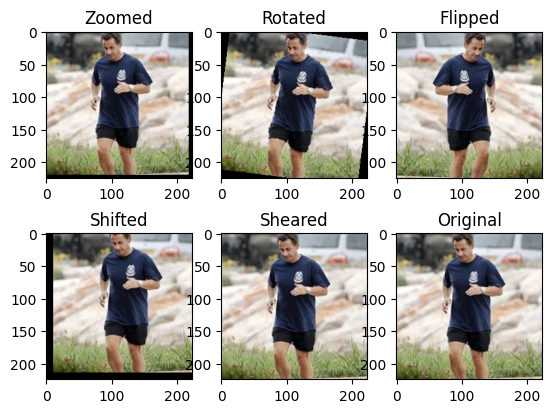

In [ ]:
train_images_augmented, train_labels_augmented = augment_images(X_train_Standford, 
                                                                y_train_Standford,
                                                                width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                shear_range=0.2,
                                                                zoom_range=0.2)

### Visualize a photo from the training files and also print its label

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image_no = 234  # change this to a number between [0, 1200] and you can see a different training image
img = cv2.imread(f'Stanford40/JPEGImages/{train_files_st[image_no]}')
print(f'An image with the label - {train_labels_st[image_no]}')
cv2_imshow(img)

# Human Motion Database 51 (HMDB51)


## Download the dataset

In [ ]:
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

--2023-04-15 17:59:07--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2023-04-15 17:59:07--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  88.5MB/s    in 24s     

2023-04-15 17:59:32 (83.1 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]

--2023-04-15 17:59:32--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
R

## Extract and organize the data.

In [ ]:
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar



UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  test_train_splits/brush_hair_test_split1.txt                   0%  OK 
Extracting  test_train_splits/brush_hair_test_split2.txt                   1%  OK 
Extracting  test_train_splits/brush_hair_test_split3.txt                   1%  OK 
Extracting  test_train_splits/cartwheel_test_split1.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split2.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split3.txt                    3%  OK 
Extracting  test_train_splits/catch_test_split1.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split2.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split3.txt                        5%  OK 
Extracting  test_train_splits/chew_test_split1.txt       

## Split the dataset into train and test 

In [ ]:
import glob

TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(train_files)}):\n\t{train_files}')
#print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
#      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
#print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
 #     f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (840):
	['11408ErikaRecurvefront_shoot_bow_u_nm_np1_fr_med_0.avi', '11408ErikaRecurvefront_shoot_bow_u_nm_np1_fr_med_1.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_0.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_1.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_2.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_3.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_4.avi', '6arrowswithin30seconds_shoot_bow_f_nm_np1_fr_med_5.avi', 'ArcherShootsFOBArrowat100Yards_shoot_bow_u_nm_np1_fr_med_0.avi', 'ArcherShootsFOBArrowat100Yards_shoot_bow_u_nm_np1_fr_med_1.avi', 'ArcherySVK_shoot_bow_u_cm_np1_fr_med_0.avi', 'ArcherySVK_shoot_bow_u_cm_np1_fr_med_1.avi', 'ArcherySVK_shoot_bow_u_cm_np1_fr_med_2.avi', 'Erikafrontrecurve6june08_shoot_bow_u_nm_np1_fr_med_0.avi', 'Fellowship_5_shoot_bow_h_cm_np1_fr_med_7.avi', 'Fellowship_5_shoot_bow_h_nm_np1_fr_goo_3.avi', 'Fellowship_5_shoot_bow_h_nm_np1_fr_goo_4.avi', 'Fellowship_5_shoot_bow_u_cm_np1_fr_med_1

## Load video data and save the middle frame and Optical Flow

### Run if first time. Get the optical flow. 


In [ ]:
def optical_flow(files, labels):

  # Define the number of optical flow frames to stack together
  num_of_frames = 16

  # Define the path to the main folder containing the video data
  video_data_path = "video_data/" 

  # Create an empty list to store the optical flow stacks
  optical_flow_stacks = []

  # Loop through each video file in the test_files list
  for file_name, label in zip(files, labels):
      
      # Define the path to the folder containing the video file
      folder_path = os.path.join(video_data_path, label)
      
      #path_class = os.path.join(optical_flow_folder_path,label)

      # Define the path to the video file
      video_path = os.path.join(folder_path, file_name)
      
      # Load the video file using OpenCV
      cap = cv2.VideoCapture(video_path)
      
      # Determine the total number of frames in the video
      num_of_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      
      # Create an empty list to store the optical flow frames
      optical_flow_frames = []

      # Get the total number of frames
      total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

      # Calculate the middle frame
      middle_frame = int(total_frames / 2)
      
      # Loop through the frames and extract the optical flow frames
      for i in range(num_of_frames):
        
          # Set the frame index
          #frame_index = i * step_size
          
          # Read the frame
          cap.set(cv2.CAP_PROP_POS_FRAMES, i+middle_frame-8)
          ret, frame = cap.read()
          
          if not ret:
              break
          
          # Convert the frame to grayscale
          gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

          # Crop and resize every frame 
          h, w = gray.shape[:2]
          center_x = int(w/2)
          center_y = int(h/2)
          length = min(h, w)
          start_x = center_x - int(length/2)
          start_y = center_y - int(length/2)
          cropped_img = gray[start_y:start_y+length, start_x:start_x+length]
          resized_img = cv2.resize(cropped_img, (112, 112))
          normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
          
          if i == 0:
              # Initialize the previous frame
              prev_frame = normalized
              
          else:

              # Compute the optical flow between the current and previous frames
              flow = cv2.calcOpticalFlowFarneback(prev_frame, normalized, None, 0.5, 3, 15, 3, 5, 1.2, 0)
              
              # Normalize the optical flow values
              flow_norm = cv2.normalize(flow, None, 0, 255, cv2.NORM_MINMAX)
            
              # Append the optical flow frame to the list
              optical_flow_frames.append(flow_norm)
              
              # Update the previous frame
              prev_frame = normalized
              
              #img_3channel = np.concatenate((flow_norm, np.zeros((flow_norm.shape[0], flow_norm.shape[1], 1))), axis=2)

              #if not os.path.exists(path_class):
               # os.makedirs(path_class)

              #tf.keras.utils.save_img(
              #path_class+f'/{str(os.path.splitext(file_name)[0])}' +'.png', img_3channel, data_format='channels_last', file_format='png', scale=True)

      # Stack the optical flow frames together
      if len(optical_flow_frames) < num_of_frames:
          optical_flow_frames += [np.zeros_like(optical_flow_frames[-1]) for _ in range(num_of_frames - len(optical_flow_frames))]
      
      optical_flow_stack = np.stack(optical_flow_frames, axis=2)

      # save the image in the TIFF format
      # np.save(f'{path_class}'+f'/{str(os.path.splitext(file_name)[0])}'+'.png',np.array(optical_flow_frames))
      
      # Append the optical flow stack to the list
      optical_flow_stacks.append(optical_flow_stack)
      
      # Release the video capture object
      cap.release()

  return np.array(optical_flow_stacks), np.array(labels)

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf 

# Create optical flow
#of_test_images, of_test_labels = optical_flow(test_files,test_labels)

#of_path_test = os.path.join('/content/drive/My Drive/Computer_Vision/Assignment_5/', 'optical_flow_train_16_channels')
of_train_images, of_train_labels  = optical_flow(train_files,train_labels)

# Save the optical flows and the labels 
#np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_test_images.npy', of_test_images)
#np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_test_labels.npy', of_test_labels)
#np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_images.npy', of_train_images)
#np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_labels.npy', of_train_labels)

In [ ]:
np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_images.npy', of_train_images)
np.save('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_labels.npy', of_train_labels)

### Get and save the middle frame of each video. 

In [ ]:
def read_middle_frame(test_files,test_labels,md_folder_path,video_data_path):
    # Loop through each video file in the test_files list
  for file_name, label in zip(test_files, test_labels):
      
      # Define the path to the folder containing the video file
      folder_path = os.path.join(video_data_path, label)

      path_class = os.path.join(md_folder_path,label)
      
      # Define the path to the video file
      video_path = os.path.join(folder_path, file_name)
      
      # Open the video file
      cap = cv2.VideoCapture(video_path)

      # Get the total number of frames
      total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

      # Calculate the middle frame
      middle_frame = int(total_frames / 2)

      # Set the frame position to the middle frame
      cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame)

      # Read the middle frame
      ret, frame = cap.read()
      
      # Convert the image from BGR to RGB
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      # Get the height and width of the image
      h, w = frame.shape[:2]

      # Calculate the center coordinates of the image
      center_x = int(w/2)
      center_y = int(h/2)

      # Calculate the length of the side of the square
      length = min(h, w)

      # Calculate the coordinates of the top left corner of the square
      start_x = center_x - int(length/2)
      start_y = center_y - int(length/2)

      # Crop the image to the square
      cropped_img = frame[start_y:start_y+length, start_x:start_x+length]

      # Resize the square to 200x200
      resized_img = cv2.resize(cropped_img, (224, 224))

      # Normalize the image
      normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

      if not os.path.exists(path_class):
        os.makedirs(path_class)

      tf.keras.utils.save_img(
        path_class+f'/{str(os.path.splitext(file_name)[0])}' +'.png', normalized, data_format='channels_last', file_format='png', scale=True)

      cap.release()


In [ ]:
# Define the path to the main folder containing the video data
video_data_path = "video_data/"

# Create an empty list to store the optical flow stacks
mf_stacks = []

# Create the folder to store optical flow frames
md_folder_path = os.path.join('/content/drive/My Drive/Computer_Vision_2/Assignment_5/', 'middle_frame_test')

read_middle_frame(test_files, test_labels, md_folder_path, video_data_path)

# Create the folder to store optical flow frames
md_folder_path = os.path.join('/content/drive/My Drive/Computer_Vision_2/Assignment_5/', 'middle_frame_train')

read_middle_frame(train_files,train_labels,md_folder_path, video_data_path)

# Models

## Model 1 

#### Without data augmentation

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 111, 111, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                      

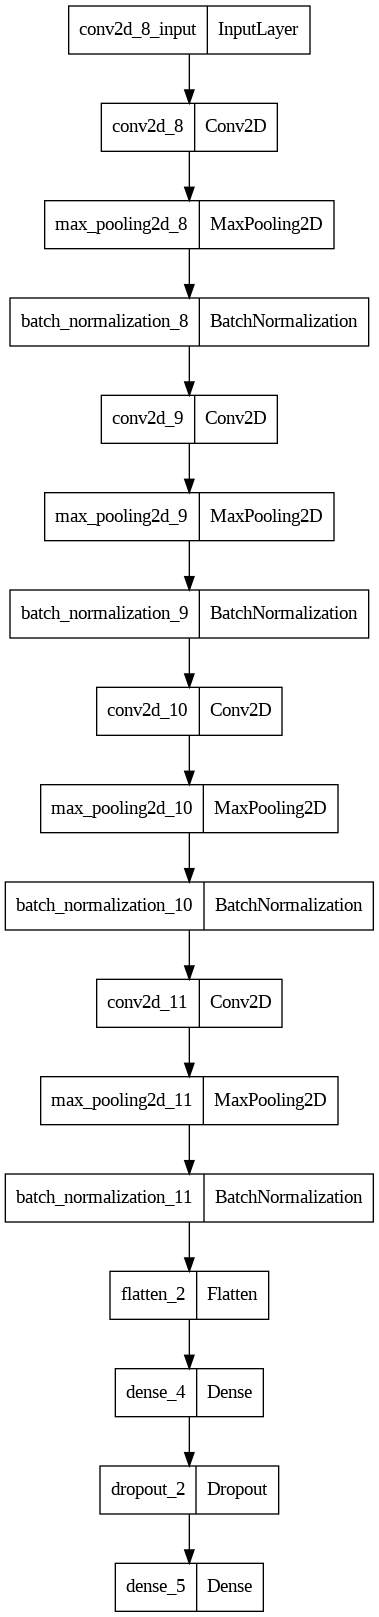

In [ ]:
import tensorflow as tf

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])
  
model_1.summary()
from keras.utils.vis_utils import plot_model
plot_model(model_1)

6
Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 3.4621 - accuracy: 0.0952
Epoch 1: val_accuracy improved from -inf to 0.10219, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 21s 182ms/step - loss: 3.4621 - accuracy: 0.0952 - val_loss: 2.6953 - val_accuracy: 0.1022 - lr: 1.0000e-05
6
Epoch 2/25
38/39 [============================>.] - ETA: 0s - loss: 5.4802 - accuracy: 0.2311
Epoch 2: val_accuracy improved from 0.10219 to 0.14599, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 118ms/step - loss: 5.5052 - accuracy: 0.2294 - val_loss: 7.1205 - val_accuracy: 0.1460 - lr: 0.0017
6
Epoch 3/25
38/39 [============================>.] - ETA: 0s - loss: 5.0770 - accuracy: 0.2611
Epoch 3: val_accuracy did not improve from 0.14599
39/39 [==============================] - 2s 54ms/step - loss: 5.0694 - accuracy: 0.2607 - val_loss: 14.8678 - val_accuracy: 0.1460 - lr: 0.0033
6
Epoch 4/25
38/39 [============================>.] - ETA: 0s - loss: 2.7471 - accuracy: 0.2463
Epoch 4: val_accuracy improved from 0.14599 to 0.20803, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 6s 153ms/step - loss: 2.7398 - accuracy: 0.2468 - val_loss: 7.9600 - val_accuracy: 0.2080 - lr: 0.0050
6
Epoch 5/25
38/39 [============================>.] - ETA: 0s - loss: 2.2022 - accuracy: 0.2743
Epoch 5: val_accuracy did not improve from 0.20803
39/39 [==============================] - 2s 54ms/step - loss: 2.2054 - accuracy: 0.2725 - val_loss: 4.3818 - val_accuracy: 0.1788 - lr: 0.0067
6
Epoch 6/25
38/39 [============================>.] - ETA: 0s - loss: 2.1612 - accuracy: 0.2821
Epoch 6: val_accuracy did not improve from 0.20803
39/39 [==============================] - 2s 59ms/step - loss: 2.1621 - accuracy: 0.2810 - val_loss: 3.6274 - val_accuracy: 0.1898 - lr: 0.0083
6
Epoch 7/25
38/39 [============================>.] - ETA: 0s - loss: 2.1648 - accuracy: 0.2989
Epoch 7: val_accuracy improved from 0.20803 to 0.25912, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 6s 156ms/step - loss: 2.1628 - accuracy: 0.3001 - val_loss: 2.4826 - val_accuracy: 0.2591 - lr: 0.0100
6
Epoch 8/25
38/39 [============================>.] - ETA: 0s - loss: 2.0522 - accuracy: 0.3298
Epoch 8: val_accuracy improved from 0.25912 to 0.26642, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 131ms/step - loss: 2.0455 - accuracy: 0.3322 - val_loss: 4.1736 - val_accuracy: 0.2664 - lr: 0.0083
6
Epoch 9/25
38/39 [============================>.] - ETA: 0s - loss: 1.8802 - accuracy: 0.3750
Epoch 9: val_accuracy improved from 0.26642 to 0.32117, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 118ms/step - loss: 1.8804 - accuracy: 0.3754 - val_loss: 2.6250 - val_accuracy: 0.3212 - lr: 0.0067
6
Epoch 10/25
38/39 [============================>.] - ETA: 0s - loss: 1.6567 - accuracy: 0.4465
Epoch 10: val_accuracy improved from 0.32117 to 0.32482, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 132ms/step - loss: 1.6543 - accuracy: 0.4477 - val_loss: 2.2141 - val_accuracy: 0.3248 - lr: 0.0050
6
Epoch 11/25
38/39 [============================>.] - ETA: 0s - loss: 1.3771 - accuracy: 0.5201
Epoch 11: val_accuracy improved from 0.32482 to 0.36131, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 132ms/step - loss: 1.3732 - accuracy: 0.5214 - val_loss: 2.0796 - val_accuracy: 0.3613 - lr: 0.0033
6
Epoch 12/25
38/39 [============================>.] - ETA: 0s - loss: 1.1872 - accuracy: 0.5929
Epoch 12: val_accuracy improved from 0.36131 to 0.38321, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 5s 117ms/step - loss: 1.1851 - accuracy: 0.5921 - val_loss: 1.9587 - val_accuracy: 0.3832 - lr: 0.0017
6
Epoch 13/25
38/39 [============================>.] - ETA: 0s - loss: 1.0211 - accuracy: 0.6336
Epoch 13: val_accuracy did not improve from 0.38321
39/39 [==============================] - 2s 57ms/step - loss: 1.0201 - accuracy: 0.6328 - val_loss: 1.9445 - val_accuracy: 0.3832 - lr: 1.0000e-05
6
Epoch 14/25
38/39 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.6382
Epoch 14: val_accuracy improved from 0.38321 to 0.42336, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1


39/39 [==============================] - 7s 175ms/step - loss: 1.0017 - accuracy: 0.6373 - val_loss: 1.8836 - val_accuracy: 0.4234 - lr: 0.0017
6
Epoch 15/25
38/39 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.6620
Epoch 15: val_accuracy did not improve from 0.42336
39/39 [==============================] - 2s 56ms/step - loss: 0.9474 - accuracy: 0.6608 - val_loss: 1.9756 - val_accuracy: 0.3869 - lr: 0.0033
6
Epoch 16/25
38/39 [============================>.] - ETA: 0s - loss: 0.9622 - accuracy: 0.6591
Epoch 16: val_accuracy did not improve from 0.42336
39/39 [==============================] - 2s 53ms/step - loss: 0.9660 - accuracy: 0.6580 - val_loss: 2.2749 - val_accuracy: 0.3285 - lr: 0.0050
6
Epoch 17/25
38/39 [============================>.] - ETA: 0s - loss: 1.0724 - accuracy: 0.6287
Epoch 17: val_accuracy did not improve from 0.42336
39/39 [==============================] - 2s 54ms/step - loss: 1.0746 - accuracy: 0.6283 - val_loss: 2.2183 - val_accuracy: 

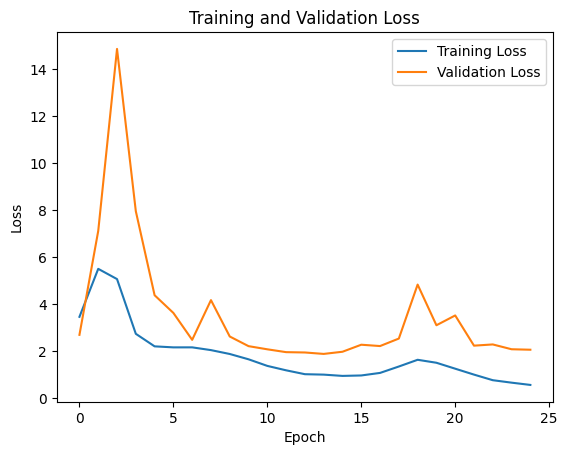

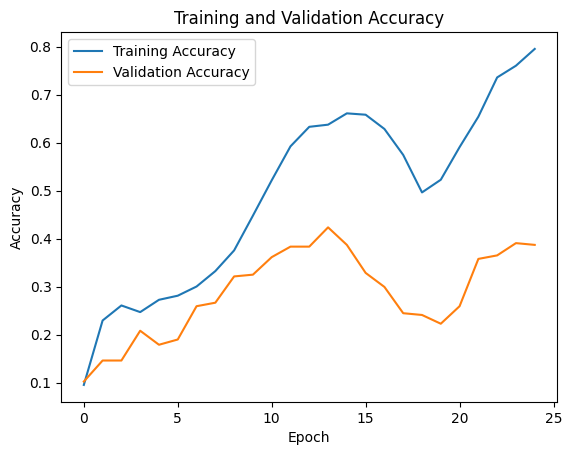

In [ ]:
train_model_CLR(model_1, X_train_Standford, y_train_Standford, X_val_Standford, y_val_Standford, 'model_1')

In [ ]:
# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1'
model_1.load_weights(model_name)

# compile the model for testing
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model_1.evaluate(test_images_Standford, test_labels_Standford)
print('Test accuracy:', test_accuracy)

10/10 [==============================] - 1s 27ms/step - loss: 2.2290 - accuracy: 0.3651
Test accuracy: 0.36513158679008484


10/10 [==============================] - 0s 7ms/step


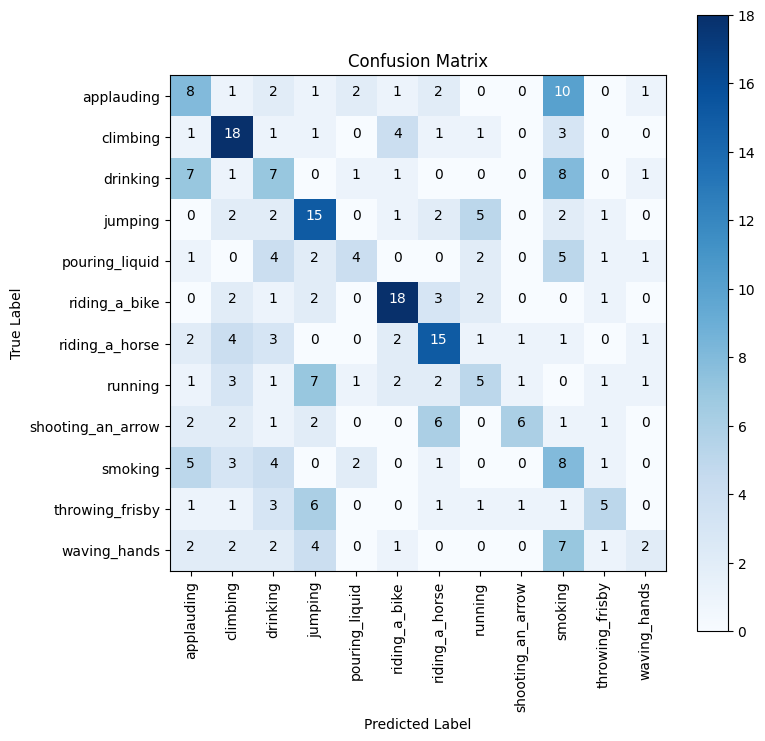

In [ ]:
# Confusion matrix Model 1 CNN Standford

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions of the model on the validation set
predictions = model_1.predict(test_images_Standford)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels_Standford, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks(np.arange(12), keep_stanford40, rotation=90)
plt.yticks(np.arange(12), keep_stanford40)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()

# Add text labels to the plot
thresh = cm.max() / 2.0
for i in range(12):
    for j in range(12):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#### Data augmentation

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

model_1.count_params()

4820332

Epoch 1/15


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


462/462 [==============================] - 28s 28ms/step - loss: 2.7894 - accuracy: 0.1867 - val_loss: 2.0597 - val_accuracy: 0.3212
Epoch 2/15
462/462 [==============================] - 12s 27ms/step - loss: 2.1316 - accuracy: 0.2710 - val_loss: 2.0291 - val_accuracy: 0.3686
Epoch 3/15
462/462 [==============================] - 12s 27ms/step - loss: 1.9300 - accuracy: 0.3377 - val_loss: 1.8884 - val_accuracy: 0.4088
Epoch 4/15
462/462 [==============================] - 13s 27ms/step - loss: 1.7428 - accuracy: 0.3993 - val_loss: 1.8038 - val_accuracy: 0.4124
Epoch 5/15
462/462 [==============================] - 12s 27ms/step - loss: 1.5474 - accuracy: 0.4669 - val_loss: 1.7939 - val_accuracy: 0.4343
Epoch 6/15
462/462 [==============================] - 12s 27ms/step - loss: 1.3407 - accuracy: 0.5386 - val_loss: 1.9944 - val_accuracy: 0.4453
Epoch 7/15
462/462 [==============================] - 13s 27ms/step - loss: 1.1523 - accuracy: 0.6002 - val_loss: 1.9039 - val_accuracy: 0.4635
Epo

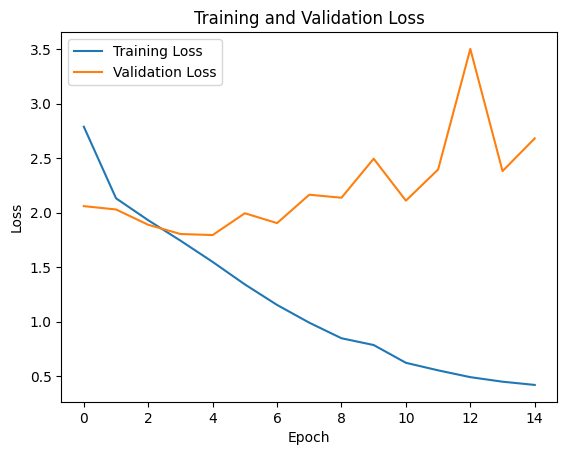

In [ ]:
# Train without Cyclical LR
train_model(model_1, train_images_augmented, train_labels_augmented, X_val_Standford, y_val_Standford)

12
Epoch 1/25
231/231 [==============================] - ETA: 0s - loss: 3.0835 - accuracy: 0.1515
Epoch 1: val_accuracy improved from -inf to 0.24088, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1_aug


231/231 [==============================] - 24s 83ms/step - loss: 3.0835 - accuracy: 0.1515 - val_loss: 2.3240 - val_accuracy: 0.2409 - lr: 1.0000e-05
12
Epoch 2/25
230/231 [============================>.] - ETA: 0s - loss: 2.4448 - accuracy: 0.2722
Epoch 2: val_accuracy improved from 0.24088 to 0.35766, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1_aug


231/231 [==============================] - 15s 63ms/step - loss: 2.4436 - accuracy: 0.2724 - val_loss: 2.5051 - val_accuracy: 0.3577 - lr: 8.4250e-04
12
Epoch 3/25
230/231 [============================>.] - ETA: 0s - loss: 1.9017 - accuracy: 0.3770
Epoch 3: val_accuracy did not improve from 0.35766
231/231 [==============================] - 12s 52ms/step - loss: 1.9010 - accuracy: 0.3771 - val_loss: 2.4404 - val_accuracy: 0.3285 - lr: 0.0017
12
Epoch 4/25
230/231 [============================>.] - ETA: 0s - loss: 1.6729 - accuracy: 0.4465
Epoch 4: val_accuracy did not improve from 0.35766
231/231 [==============================] - 12s 51ms/step - loss: 1.6735 - accuracy: 0.4464 - val_loss: 13.0527 - val_accuracy: 0.2263 - lr: 0.0025
12
Epoch 5/25
230/231 [============================>.] - ETA: 0s - loss: 1.5277 - accuracy: 0.5014
Epoch 5: val_accuracy improved from 0.35766 to 0.39051, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1_aug


231/231 [==============================] - 15s 67ms/step - loss: 1.5279 - accuracy: 0.5014 - val_loss: 2.7553 - val_accuracy: 0.3905 - lr: 0.0033
12
Epoch 6/25
230/231 [============================>.] - ETA: 0s - loss: 1.3632 - accuracy: 0.5537
Epoch 6: val_accuracy did not improve from 0.39051
231/231 [==============================] - 12s 52ms/step - loss: 1.3622 - accuracy: 0.5540 - val_loss: 2.3783 - val_accuracy: 0.3212 - lr: 0.0042
12
Epoch 7/25
230/231 [============================>.] - ETA: 0s - loss: 1.1620 - accuracy: 0.6189
Epoch 7: val_accuracy did not improve from 0.39051
231/231 [==============================] - 12s 51ms/step - loss: 1.1622 - accuracy: 0.6187 - val_loss: 2.5435 - val_accuracy: 0.3540 - lr: 0.0050
12
Epoch 8/25
230/231 [============================>.] - ETA: 0s - loss: 0.9572 - accuracy: 0.6909
Epoch 8: val_accuracy did not improve from 0.39051
231/231 [==============================] - 12s 52ms/step - loss: 0.9570 - accuracy: 0.6909 - val_loss: 2.6086 - 

231/231 [==============================] - 14s 62ms/step - loss: 0.8142 - accuracy: 0.7420 - val_loss: 3.3306 - val_accuracy: 0.4051 - lr: 0.0083
12
Epoch 12/25
230/231 [============================>.] - ETA: 0s - loss: 0.8190 - accuracy: 0.7433
Epoch 12: val_accuracy did not improve from 0.40511
231/231 [==============================] - 12s 52ms/step - loss: 0.8191 - accuracy: 0.7432 - val_loss: 3.4889 - val_accuracy: 0.3139 - lr: 0.0092
12
Epoch 13/25
230/231 [============================>.] - ETA: 0s - loss: 0.9376 - accuracy: 0.7185
Epoch 13: val_accuracy did not improve from 0.40511
231/231 [==============================] - 12s 52ms/step - loss: 0.9371 - accuracy: 0.7187 - val_loss: 3.0418 - val_accuracy: 0.3686 - lr: 0.0100
12
Epoch 14/25
230/231 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.7522
Epoch 14: val_accuracy did not improve from 0.40511
231/231 [==============================] - 13s 55ms/step - loss: 0.8112 - accuracy: 0.7523 - val_loss: 2.3

231/231 [==============================] - 14s 62ms/step - loss: 0.7214 - accuracy: 0.7826 - val_loss: 3.8477 - val_accuracy: 0.4343 - lr: 0.0083
12
Epoch 16/25
230/231 [============================>.] - ETA: 0s - loss: 0.5594 - accuracy: 0.8293
Epoch 16: val_accuracy did not improve from 0.43431
231/231 [==============================] - 12s 53ms/step - loss: 0.5594 - accuracy: 0.8294 - val_loss: 3.3403 - val_accuracy: 0.4051 - lr: 0.0075
12
Epoch 17/25
230/231 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.8556
Epoch 17: val_accuracy did not improve from 0.43431
231/231 [==============================] - 12s 52ms/step - loss: 0.4553 - accuracy: 0.8558 - val_loss: 3.6109 - val_accuracy: 0.4270 - lr: 0.0067
12
Epoch 18/25
230/231 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8849
Epoch 18: val_accuracy did not improve from 0.43431
231/231 [==============================] - 12s 52ms/step - loss: 0.3614 - accuracy: 0.8849 - val_loss: 2.3

231/231 [==============================] - 15s 64ms/step - loss: 0.2559 - accuracy: 0.9152 - val_loss: 3.3662 - val_accuracy: 0.4854 - lr: 0.0042
12
Epoch 21/25
230/231 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9285
Epoch 21: val_accuracy did not improve from 0.48540
231/231 [==============================] - 12s 53ms/step - loss: 0.2139 - accuracy: 0.9286 - val_loss: 3.3112 - val_accuracy: 0.4124 - lr: 0.0033
12
Epoch 22/25
230/231 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9445
Epoch 22: val_accuracy did not improve from 0.48540
231/231 [==============================] - 12s 52ms/step - loss: 0.1665 - accuracy: 0.9445 - val_loss: 2.7585 - val_accuracy: 0.4197 - lr: 0.0025
12
Epoch 23/25
230/231 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9516
Epoch 23: val_accuracy did not improve from 0.48540
231/231 [==============================] - 13s 57ms/step - loss: 0.1393 - accuracy: 0.9517 - val_loss: 3.2

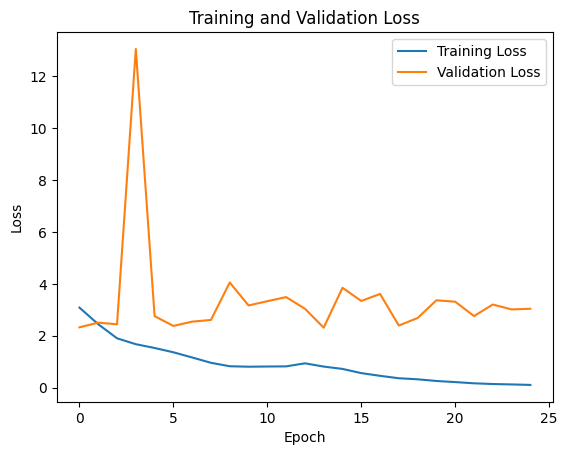

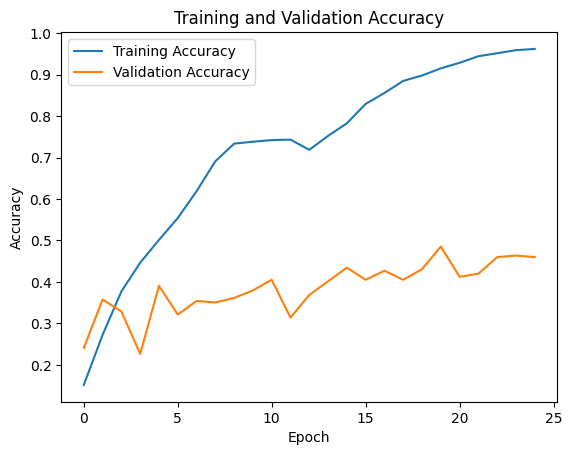

In [ ]:
# Train with Cyclical LR
train_model_CLR(model_1, train_images_augmented, train_labels_augmented, X_val_Standford, y_val_Standford, 'model_1_aug', data_augmentation=True)

In [ ]:
# load weights for best validation performance 0.51825
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1_aug'
model_1.load_weights(model_name)

In [ ]:
# compile the model 
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model_1.evaluate(test_images_Standford, test_labels_Standford, batch_size=64)
print('Test accuracy:', test_accuracy)

5/5 [==============================] - 1s 116ms/step - loss: 2.9767 - accuracy: 0.4474
Test accuracy: 0.44736841320991516


10/10 [==============================] - 0s 14ms/step


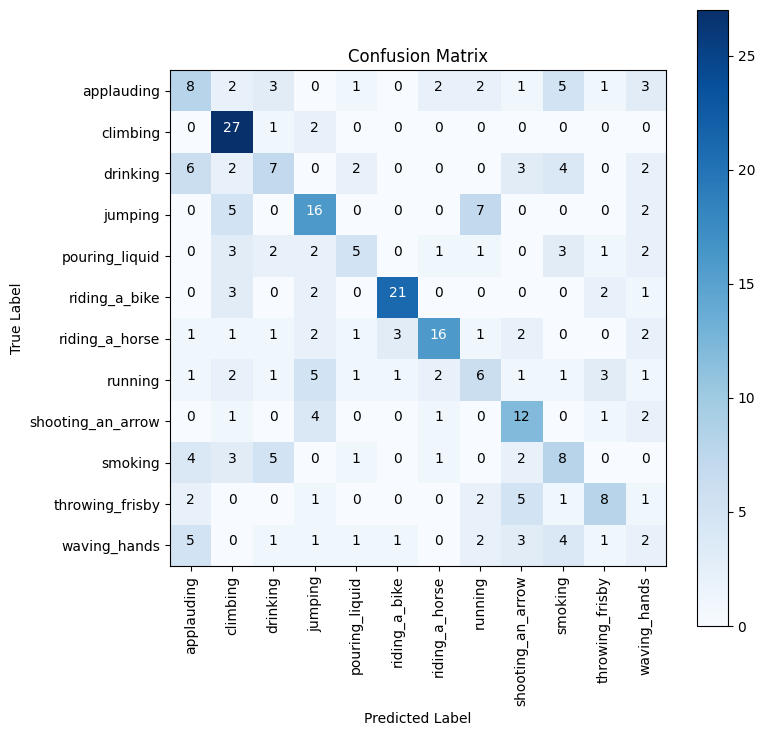

In [ ]:
# Confusion matrix Model 1 CNN Standford

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions of the model on the validation set
predictions = model_1.predict(test_images_Standford)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels_Standford, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks(np.arange(12), keep_stanford40, rotation=90)
plt.yticks(np.arange(12), keep_stanford40)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()

# Add text labels to the plot
thresh = cm.max() / 2.0
for i in range(12):
    for j in range(12):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

## Model 2: HMDB51 – Frames (transfer learning):

#### Load the middle frame images

In [ ]:
import cv2 as cv
def middle_frame(image_files, image_labels, video_data_path):
  
  input_shape = (224, 224, 3)

  images, labels = [], []
  for file_name, label in zip(image_files, image_labels):
      
      folder_path = os.path.join(video_data_path, label)
      
      video_path = os.path.join(folder_path, file_name)
      cap = cv2.VideoCapture(video_path)

      # Get the total number of frames
      total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      middle_frame = int(total_frames / 2)

      cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame)
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      h, w = frame.shape[:2]
      center_x = int(w/2)
      center_y = int(h/2)
      length = min(h, w)
      start_x = center_x - int(length/2)
      start_y = center_y - int(length/2)
      cropped_img = frame[start_y:start_y+length, start_x:start_x+length]
      resized_img = cv2.resize(cropped_img, (224, 224))
      normalized = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

      images.append(normalized)
      labels.append(label)
     
      cap.release()

  images = np.array(images)
  images = images.reshape(-1, input_shape[0], input_shape[1], 3)
  labels = np.array(labels)

  return images, labels

video_data_path = "video_data/"

x_train_HMBD, labels_train_HMBD = middle_frame(train_files, train_labels, video_data_path)
x_test_HMBD, labels_test_HMBD = middle_frame(test_files, test_labels, video_data_path)

y_train_HMBD = []
for label in labels_train_HMBD:
    y_train_HMBD.append(keep_hmdb51.index(label))
y_train_HMBD= np.array(y_train_HMBD)

y_test_HMBD = []
for label in labels_test_HMBD:
    y_test_HMBD.append(keep_hmdb51.index(label))
y_test_HMBD = np.array(y_test_HMBD)

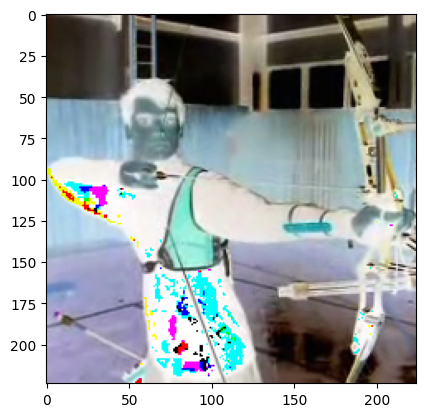

In [ ]:
plt.imshow((x_train_HMBD[10]*255).astype(np.uint8))
plt.show()

In [ ]:
X_train_HMDB51, X_val_HMDB51, y_train_HMDB51, y_val_HMDB51 = train_test_split(x_train_HMBD, y_train_HMBD, test_size=0.1, stratify=y_train_HMBD)

x_train_HMBD_augmented, y_train_HMBD_augmented = augment_images(x_train_HMBD, 
                                                                y_train_HMBD,
                                                                width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                shear_range=0.2,
                                                                zoom_range=0.2)

#### Model 2

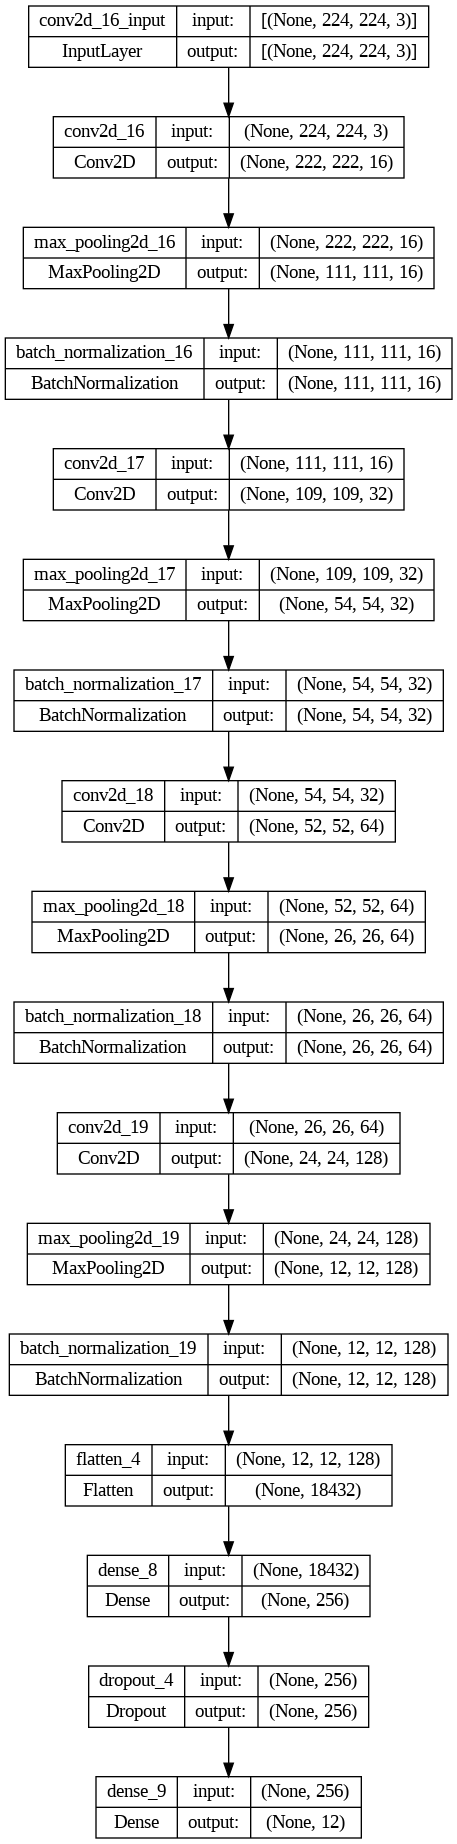

In [ ]:
from keras.models import load_model

pretrained_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_1_aug'  # ESTOY CARGANDO LAS AUGMENTED 

pretrained_model.load_weights(model_name)
plot_model(pretrained_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False
    
# Unfreeze the last 3 layers
for layer in pretrained_model.layers[-3:]:
    layer.trainable = True

8
Epoch 1/25
24/24 [==============================] - ETA: 0s - loss: 5.7689 - accuracy: 0.2156
Epoch 1: val_accuracy improved from -inf to 0.27381, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2


24/24 [==============================] - 4s 137ms/step - loss: 5.7689 - accuracy: 0.2156 - val_loss: 4.7286 - val_accuracy: 0.2738 - lr: 1.0000e-05
8
Epoch 2/25
23/24 [===========================>..] - ETA: 0s - loss: 2.5079 - accuracy: 0.3111
Epoch 2: val_accuracy improved from 0.27381 to 0.32143, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2


24/24 [==============================] - 2s 102ms/step - loss: 2.4932 - accuracy: 0.3122 - val_loss: 2.1621 - val_accuracy: 0.3214 - lr: 0.0013
8
Epoch 3/25
22/24 [==========================>...] - ETA: 0s - loss: 1.8277 - accuracy: 0.3736
Epoch 3: val_accuracy did not improve from 0.32143
24/24 [==============================] - 0s 15ms/step - loss: 1.8241 - accuracy: 0.3770 - val_loss: 2.0535 - val_accuracy: 0.3095 - lr: 0.0025
8
Epoch 4/25
23/24 [===========================>..] - ETA: 0s - loss: 1.6618 - accuracy: 0.4701
Epoch 4: val_accuracy improved from 0.32143 to 0.38095, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2


24/24 [==============================] - 3s 121ms/step - loss: 1.6722 - accuracy: 0.4669 - val_loss: 2.1141 - val_accuracy: 0.3810 - lr: 0.0038
8
Epoch 5/25
21/24 [=========================>....] - ETA: 0s - loss: 1.7352 - accuracy: 0.4702
Epoch 5: val_accuracy did not improve from 0.38095
24/24 [==============================] - 0s 19ms/step - loss: 1.7311 - accuracy: 0.4656 - val_loss: 2.1930 - val_accuracy: 0.3333 - lr: 0.0050
8
Epoch 6/25
20/24 [========================>.....] - ETA: 0s - loss: 1.8213 - accuracy: 0.4688
Epoch 6: val_accuracy improved from 0.38095 to 0.44048, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2


24/24 [==============================] - 3s 126ms/step - loss: 1.8418 - accuracy: 0.4616 - val_loss: 1.9903 - val_accuracy: 0.4405 - lr: 0.0063
8
Epoch 7/25
21/24 [=========================>....] - ETA: 0s - loss: 2.1173 - accuracy: 0.4628
Epoch 7: val_accuracy did not improve from 0.44048
24/24 [==============================] - 0s 14ms/step - loss: 2.1855 - accuracy: 0.4590 - val_loss: 2.1827 - val_accuracy: 0.3095 - lr: 0.0075
8
Epoch 8/25
21/24 [=========================>....] - ETA: 0s - loss: 2.2593 - accuracy: 0.4405
Epoch 8: val_accuracy did not improve from 0.44048
24/24 [==============================] - 0s 12ms/step - loss: 2.2480 - accuracy: 0.4339 - val_loss: 2.1015 - val_accuracy: 0.3095 - lr: 0.0088
8
Epoch 9/25
23/24 [===========================>..] - ETA: 0s - loss: 2.4853 - accuracy: 0.4429
Epoch 9: val_accuracy did not improve from 0.44048
24/24 [==============================] - 0s 12ms/step - loss: 2.5102 - accuracy: 0.4458 - val_loss: 2.3601 - val_accuracy: 0.2738

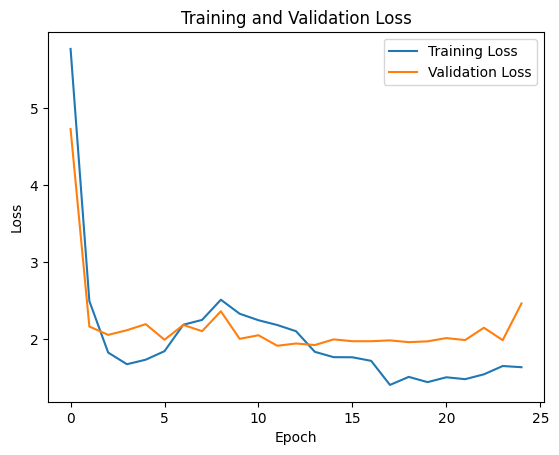

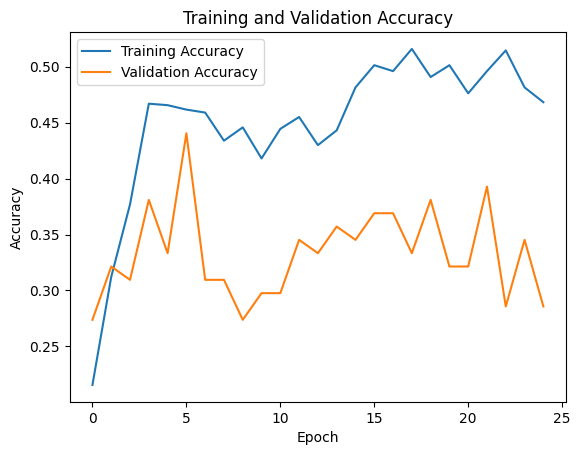

TypeError: ignored

In [ ]:
train_model2_CLR(pretrained_model, X_train_HMDB51, y_train_HMDB51, X_val_HMDB51, y_val_HMDB51, 'model_2')

In [ ]:
# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2'
pretrained_model.load_weights(model_name)
# compile the model 
pretrained_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_loss, test_accuracy = pretrained_model.evaluate(x_test_HMBD, y_test_HMBD, batch_size=64)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 1s 100ms/step - loss: 2.6224 - accuracy: 0.2389
Test accuracy: 0.23888888955116272


### Data augmenteation

In [ ]:
# Augmented data
pretrained_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])


model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2_aug'

pretrained_model.load_weights(model_name)

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False
    
# Unfreeze the last 3 layers
for layer in pretrained_model.layers[-3:]:
    layer.trainable = True

pretrained_model.count_params()

4820332

16
Epoch 1/25
158/158 [==============================] - ETA: 0s - loss: 1.5335 - accuracy: 0.5302
Epoch 1: val_accuracy improved from -inf to 0.80952, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2_aug


158/158 [==============================] - 8s 31ms/step - loss: 1.5335 - accuracy: 0.5302 - val_loss: 0.5604 - val_accuracy: 0.8095 - lr: 1.0000e-05
16
Epoch 2/25
158/158 [==============================] - ETA: 0s - loss: 1.4748 - accuracy: 0.5244
Epoch 2: val_accuracy did not improve from 0.80952
158/158 [==============================] - 2s 13ms/step - loss: 1.4748 - accuracy: 0.5244 - val_loss: 0.5769 - val_accuracy: 0.8095 - lr: 6.3438e-04
16
Epoch 3/25
155/158 [============================>.] - ETA: 0s - loss: 1.3502 - accuracy: 0.5411
Epoch 3: val_accuracy did not improve from 0.80952
158/158 [==============================] - 2s 13ms/step - loss: 1.3507 - accuracy: 0.5413 - val_loss: 0.5694 - val_accuracy: 0.8095 - lr: 0.0013
16
Epoch 4/25
157/158 [============================>.] - ETA: 0s - loss: 1.2866 - accuracy: 0.5537
Epoch 4: val_accuracy did not improve from 0.80952
158/158 [==============================] - 2s 15ms/step - loss: 1.2854 - accuracy: 0.5542 - val_loss: 0.550

158/158 [==============================] - 8s 53ms/step - loss: 1.2636 - accuracy: 0.5653 - val_loss: 0.5287 - val_accuracy: 0.8333 - lr: 0.0025
16
Epoch 6/25
156/158 [============================>.] - ETA: 0s - loss: 1.2415 - accuracy: 0.5683
Epoch 6: val_accuracy did not improve from 0.83333
158/158 [==============================] - 2s 11ms/step - loss: 1.2417 - accuracy: 0.5681 - val_loss: 0.5482 - val_accuracy: 0.8333 - lr: 0.0031
16
Epoch 7/25
153/158 [============================>.] - ETA: 0s - loss: 1.2095 - accuracy: 0.5784
Epoch 7: val_accuracy did not improve from 0.83333
158/158 [==============================] - 2s 12ms/step - loss: 1.2071 - accuracy: 0.5788 - val_loss: 0.5308 - val_accuracy: 0.8214 - lr: 0.0038
16
Epoch 8/25
158/158 [==============================] - ETA: 0s - loss: 1.2057 - accuracy: 0.5784
Epoch 8: val_accuracy did not improve from 0.83333
158/158 [==============================] - 2s 14ms/step - loss: 1.2057 - accuracy: 0.5784 - val_loss: 0.6126 - val_

158/158 [==============================] - 4s 26ms/step - loss: 1.2336 - accuracy: 0.5780 - val_loss: 0.5281 - val_accuracy: 0.8571 - lr: 0.0056
16
Epoch 11/25
155/158 [============================>.] - ETA: 0s - loss: 1.1941 - accuracy: 0.5921
Epoch 11: val_accuracy did not improve from 0.85714
158/158 [==============================] - 2s 11ms/step - loss: 1.1997 - accuracy: 0.5931 - val_loss: 0.5377 - val_accuracy: 0.8095 - lr: 0.0063
16
Epoch 12/25
155/158 [============================>.] - ETA: 0s - loss: 1.2295 - accuracy: 0.5881
Epoch 12: val_accuracy did not improve from 0.85714
158/158 [==============================] - 2s 10ms/step - loss: 1.2267 - accuracy: 0.5891 - val_loss: 0.5560 - val_accuracy: 0.8095 - lr: 0.0069
16
Epoch 13/25
153/158 [============================>.] - ETA: 0s - loss: 1.3078 - accuracy: 0.5944
Epoch 13: val_accuracy did not improve from 0.85714
158/158 [==============================] - 2s 10ms/step - loss: 1.3130 - accuracy: 0.5946 - val_loss: 0.5438 

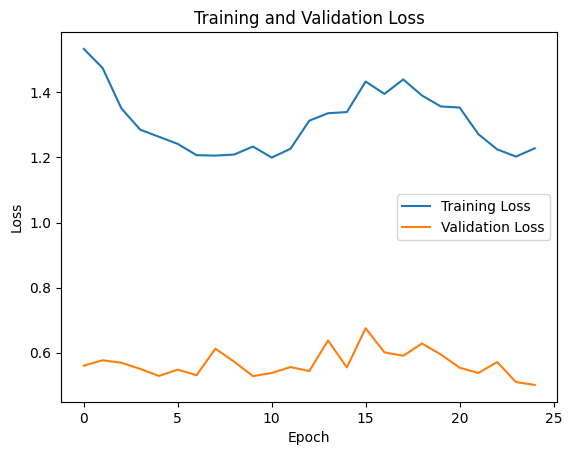

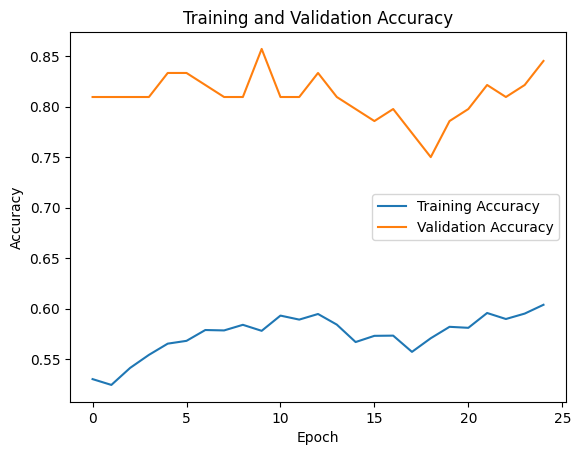

In [ ]:
train_model2_CLR(pretrained_model, x_train_HMBD_augmented, y_train_HMBD_augmented, X_val_HMDB51, y_val_HMDB51, 'model_2_aug', data_augmentation = True)

In [ ]:
# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2_aug'
pretrained_model.load_weights(model_name)

# compile the model 
pretrained_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_loss, test_accuracy = pretrained_model.evaluate(x_test_HMBD, y_test_HMBD, batch_size=64)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 0s 21ms/step - loss: 4.5127 - accuracy: 0.3222
Test accuracy: 0.3222222328186035


## Model 3: Optical flow 

### Load the optical flow images and labels

In [ ]:
of_test_images = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_test_images.npy')
of_train_images = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_images.npy')
of_test_labels_str = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_test_labels.npy')
of_train_labels_str = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_labels.npy')

In [ ]:
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

of_train_labels_str = of_train_labels_str
of_train_labels_ = []
for label in of_train_labels_str:
    of_train_labels_.append(keep_hmdb51.index(label))
of_train_labels_ = np.array(of_train_labels_)

of_test_labels_str = of_test_labels_str
of_test_labels_ = []
for label in of_test_labels_str:
    of_test_labels_.append(keep_hmdb51.index(label))
of_test_labels_ = np.array(of_test_labels_)

### Create and train the model 

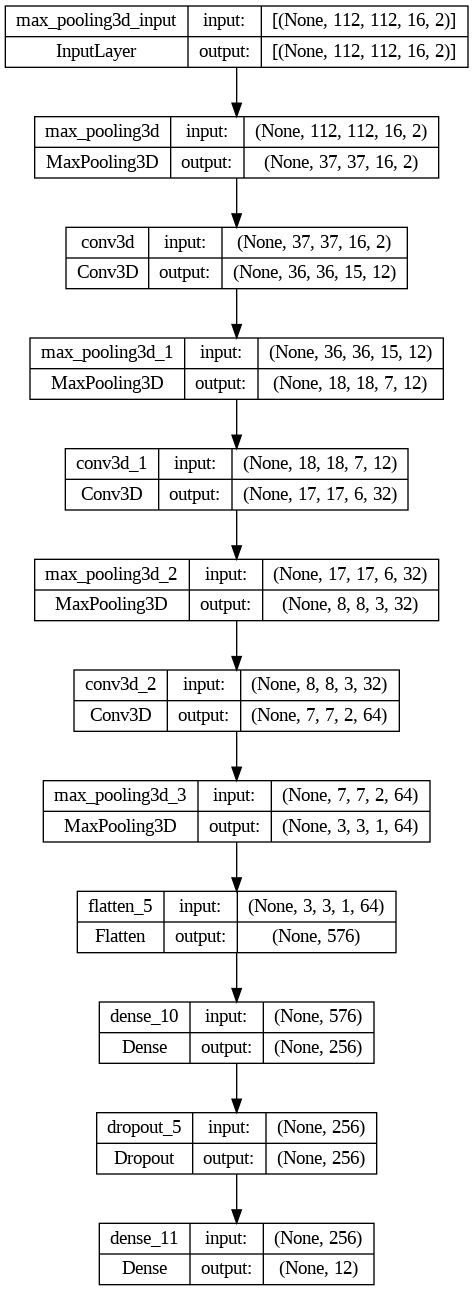

In [ ]:
model_3= Sequential()
model_3.add(MaxPooling3D(pool_size=(3, 3, 1),input_shape=(112, 112, 16, 2)))
model_3.add(Conv3D(12, (2, 2, 2), activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Conv3D(32, (2, 2, 2), activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Conv3D(64, (2, 2, 2), activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2))) # decrease pool size and stride
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(12, activation='softmax'))

model_3.count_params()
plot_model(model_3, show_shapes=True, show_layer_names=True)

6
Epoch 1/25
12/12 [==============================] - ETA: 0s - loss: 37.2670 - accuracy: 0.0860
Epoch 1: val_accuracy improved from -inf to 0.08333, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3_cyclicalLR


12/12 [==============================] - 15s 356ms/step - loss: 37.2670 - accuracy: 0.0860 - val_loss: 18.4108 - val_accuracy: 0.0833 - lr: 1.0000e-05
6
Epoch 2/25
12/12 [==============================] - ETA: 0s - loss: 13.2124 - accuracy: 0.0860
Epoch 2: val_accuracy improved from 0.08333 to 0.10714, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3_cyclicalLR


12/12 [==============================] - 3s 267ms/step - loss: 13.2124 - accuracy: 0.0860 - val_loss: 2.7351 - val_accuracy: 0.1071 - lr: 0.0017
6
Epoch 3/25
12/12 [==============================] - ETA: 0s - loss: 2.5762 - accuracy: 0.0913
Epoch 3: val_accuracy did not improve from 0.10714
12/12 [==============================] - 1s 114ms/step - loss: 2.5762 - accuracy: 0.0913 - val_loss: 2.4772 - val_accuracy: 0.0952 - lr: 0.0033
6
Epoch 4/25
12/12 [==============================] - ETA: 0s - loss: 2.4761 - accuracy: 0.1058
Epoch 4: val_accuracy did not improve from 0.10714
12/12 [==============================] - 1s 99ms/step - loss: 2.4761 - accuracy: 0.1058 - val_loss: 2.4871 - val_accuracy: 0.0952 - lr: 0.0050
6
Epoch 5/25
12/12 [==============================] - ETA: 0s - loss: 2.4873 - accuracy: 0.0939
Epoch 5: val_accuracy did not improve from 0.10714
12/12 [==============================] - 1s 98ms/step - loss: 2.4873 - accuracy: 0.0939 - val_loss: 2.4877 - val_accuracy: 0.07

12/12 [==============================] - 3s 250ms/step - loss: 2.4488 - accuracy: 0.1190 - val_loss: 2.5056 - val_accuracy: 0.1190 - lr: 0.0067
6
Epoch 10/25
12/12 [==============================] - ETA: 0s - loss: 2.4141 - accuracy: 0.1204
Epoch 10: val_accuracy improved from 0.11905 to 0.15476, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3_cyclicalLR


12/12 [==============================] - 3s 285ms/step - loss: 2.4141 - accuracy: 0.1204 - val_loss: 2.4848 - val_accuracy: 0.1548 - lr: 0.0050
6
Epoch 11/25
12/12 [==============================] - ETA: 0s - loss: 2.3969 - accuracy: 0.1402
Epoch 11: val_accuracy did not improve from 0.15476
12/12 [==============================] - 1s 101ms/step - loss: 2.3969 - accuracy: 0.1402 - val_loss: 2.6056 - val_accuracy: 0.0714 - lr: 0.0033
6
Epoch 12/25
12/12 [==============================] - ETA: 0s - loss: 2.4108 - accuracy: 0.1323
Epoch 12: val_accuracy did not improve from 0.15476
12/12 [==============================] - 1s 99ms/step - loss: 2.4108 - accuracy: 0.1323 - val_loss: 2.5499 - val_accuracy: 0.1071 - lr: 0.0017
6
Epoch 13/25
12/12 [==============================] - ETA: 0s - loss: 2.3971 - accuracy: 0.1257
Epoch 13: val_accuracy did not improve from 0.15476
12/12 [==============================] - 1s 100ms/step - loss: 2.3971 - accuracy: 0.1257 - val_loss: 2.5499 - val_accuracy

12/12 [==============================] - 3s 262ms/step - loss: 2.3474 - accuracy: 0.1653 - val_loss: 2.4229 - val_accuracy: 0.1667 - lr: 0.0050
6
Epoch 17/25
12/12 [==============================] - ETA: 0s - loss: 2.3527 - accuracy: 0.1574
Epoch 17: val_accuracy did not improve from 0.16667
12/12 [==============================] - 1s 129ms/step - loss: 2.3527 - accuracy: 0.1574 - val_loss: 2.6288 - val_accuracy: 0.1190 - lr: 0.0067
6
Epoch 18/25
12/12 [==============================] - ETA: 0s - loss: 2.4298 - accuracy: 0.1442
Epoch 18: val_accuracy did not improve from 0.16667
12/12 [==============================] - 3s 295ms/step - loss: 2.4298 - accuracy: 0.1442 - val_loss: 2.4885 - val_accuracy: 0.0833 - lr: 0.0083
6
Epoch 19/25
12/12 [==============================] - ETA: 0s - loss: 2.4172 - accuracy: 0.1243
Epoch 19: val_accuracy did not improve from 0.16667
12/12 [==============================] - 1s 99ms/step - loss: 2.4172 - accuracy: 0.1243 - val_loss: 2.5371 - val_accuracy

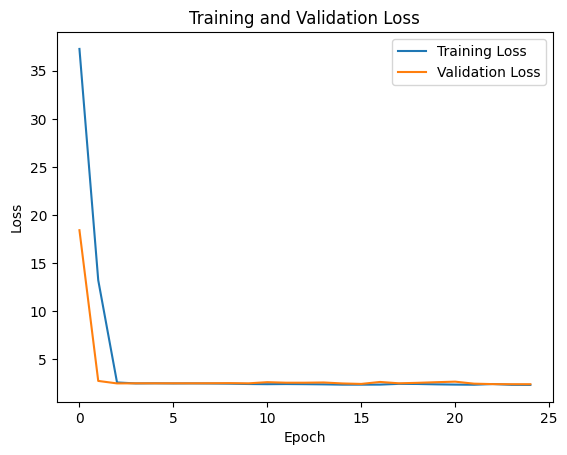

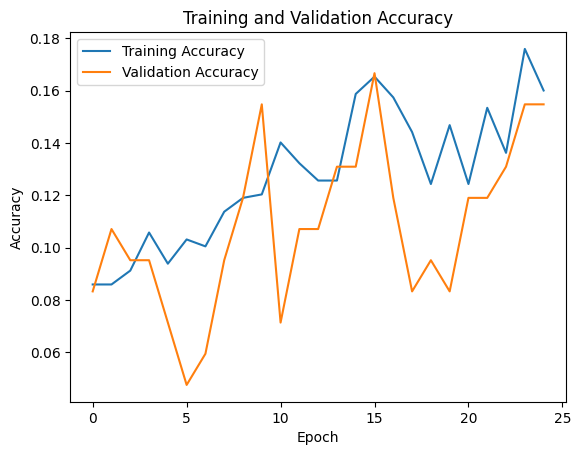

In [ ]:
# Using Cyclical LR
of_X_train, of_X_val, of_y_train, of_y_val = train_test_split(of_train_images, of_train_labels_, test_size=0.1, random_state=42)

train_model_CLR(model_3, of_X_train, of_y_train, of_X_val, of_y_val, 'model_3_cyclicalLR')

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 9.6440 - accuracy: 0.0767
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3


24/24 [==============================] - 18s 291ms/step - loss: 9.6440 - accuracy: 0.0767 - val_loss: 2.5108 - val_accuracy: 0.1429
Epoch 2/30
23/24 [===========================>..] - ETA: 0s - loss: 2.4678 - accuracy: 0.0978
Epoch 2: val_accuracy did not improve from 0.14286
24/24 [==============================] - 1s 55ms/step - loss: 2.4675 - accuracy: 0.0992 - val_loss: 2.4845 - val_accuracy: 0.0714
Epoch 3/30
23/24 [===========================>..] - ETA: 0s - loss: 2.4369 - accuracy: 0.1141
Epoch 3: val_accuracy improved from 0.14286 to 0.15476, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3


24/24 [==============================] - 3s 125ms/step - loss: 2.4342 - accuracy: 0.1151 - val_loss: 2.4829 - val_accuracy: 0.1548
Epoch 4/30
23/24 [===========================>..] - ETA: 0s - loss: 2.4212 - accuracy: 0.1318
Epoch 4: val_accuracy improved from 0.15476 to 0.17857, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3


24/24 [==============================] - 4s 174ms/step - loss: 2.4191 - accuracy: 0.1323 - val_loss: 2.4730 - val_accuracy: 0.1786
Epoch 5/30
24/24 [==============================] - ETA: 0s - loss: 2.3926 - accuracy: 0.1481
Epoch 5: val_accuracy did not improve from 0.17857
24/24 [==============================] - 2s 78ms/step - loss: 2.3926 - accuracy: 0.1481 - val_loss: 2.4763 - val_accuracy: 0.1071
Epoch 6/30
23/24 [===========================>..] - ETA: 0s - loss: 2.3635 - accuracy: 0.1658
Epoch 6: val_accuracy did not improve from 0.17857
24/24 [==============================] - 1s 46ms/step - loss: 2.3642 - accuracy: 0.1653 - val_loss: 2.4711 - val_accuracy: 0.0952
Epoch 7/30
24/24 [==============================] - ETA: 0s - loss: 2.2959 - accuracy: 0.1892
Epoch 7: val_accuracy did not improve from 0.17857
24/24 [==============================] - 1s 46ms/step - loss: 2.2959 - accuracy: 0.1892 - val_loss: 2.4405 - val_accuracy: 0.0714
Epoch 8/30
24/24 [==========================

24/24 [==============================] - 3s 132ms/step - loss: 1.7791 - accuracy: 0.4061 - val_loss: 2.4850 - val_accuracy: 0.2024
Epoch 17/30
23/24 [===========================>..] - ETA: 0s - loss: 1.7088 - accuracy: 0.4198
Epoch 17: val_accuracy did not improve from 0.20238
24/24 [==============================] - 1s 48ms/step - loss: 1.7050 - accuracy: 0.4220 - val_loss: 2.7134 - val_accuracy: 0.1190
Epoch 18/30
23/24 [===========================>..] - ETA: 0s - loss: 1.6311 - accuracy: 0.4552
Epoch 18: val_accuracy did not improve from 0.20238
24/24 [==============================] - 1s 45ms/step - loss: 1.6334 - accuracy: 0.4511 - val_loss: 2.8201 - val_accuracy: 0.0952
Epoch 19/30
24/24 [==============================] - ETA: 0s - loss: 1.6168 - accuracy: 0.4577
Epoch 19: val_accuracy did not improve from 0.20238
24/24 [==============================] - 1s 47ms/step - loss: 1.6168 - accuracy: 0.4577 - val_loss: 2.8108 - val_accuracy: 0.1190
Epoch 20/30
24/24 [===================

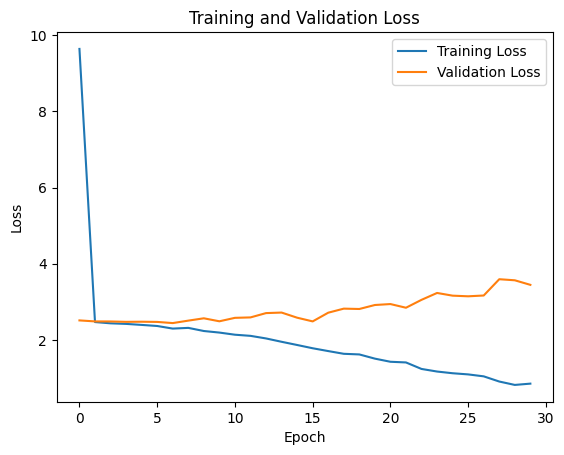

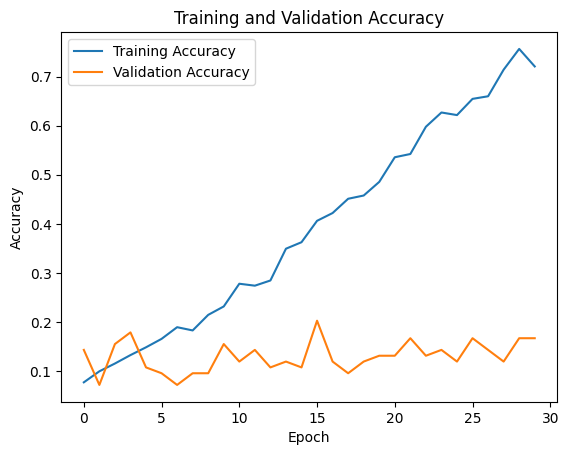

In [ ]:
# Without Cyclical LR
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

# Compile your model using the defined optimizer, loss function, and metrics
model_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Reshape the array to the desired shape
#of_train_images_reshaped = np.resize(of_train_images, (840, 32, 32, 16, 2))

of_X_train, of_X_val, of_y_train, of_y_val = train_test_split(of_train_images, of_train_labels_, test_size=0.1, random_state=42)

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3'

# define a checkpoint to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# validation_data=(of_X_val,to_categorical(of_y_val_axis, num_classes=12))
history = model_3.fit(of_X_train, to_categorical(of_y_train, num_classes=12), epochs=30,  validation_data=(of_X_val, to_categorical(of_y_val, num_classes=12)), callbacks=[checkpoint])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Test evaluation

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3'
model_3.load_weights(model_name)

test_loss, test_accuracy = model_3.evaluate(of_test_images, to_categorical(of_test_labels_, num_classes=12), batch_size=64)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 8s 76ms/step - loss: 2.6149 - accuracy: 0.1194
Test accuracy: 0.11944444477558136


12/12 [==============================] - 1s 39ms/step


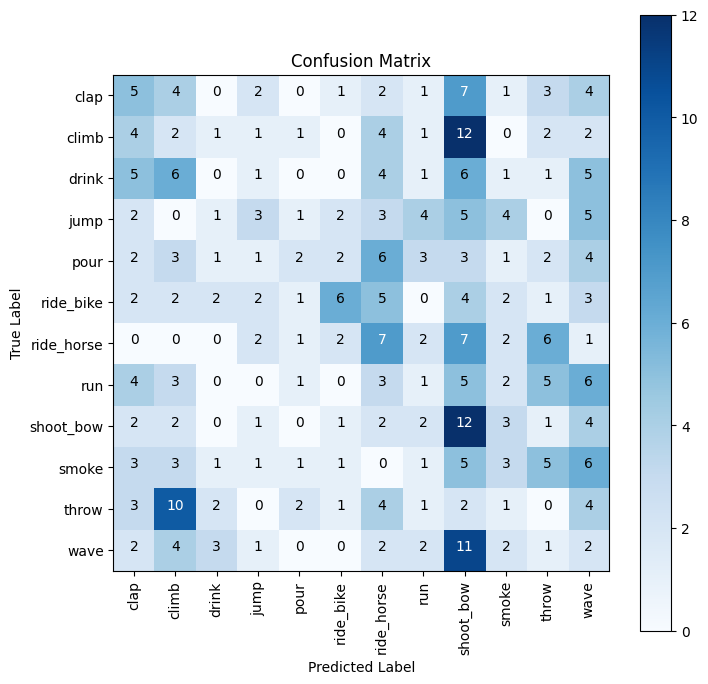

In [ ]:
# Confusion matrix Model 1 CNN Standford

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions of the model on the validation set
predictions = model_3.predict(of_test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(of_test_labels_, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks(np.arange(12), keep_hmdb51, rotation=90)
plt.yticks(np.arange(12), keep_hmdb51)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()

# Add text labels to the plot
thresh = cm.max() / 2.0
for i in range(12):
    for j in range(12):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

## Model 4

### Load the weights of the pretrained models

#### Model for the optical flow

In [ ]:
# Load the model 
model_of= Sequential()
model_of.add(MaxPooling3D(pool_size=(3, 3, 1),input_shape=(112, 112, 16, 2)))
model_of.add(Conv3D(12, (2, 2, 2), activation='relu'))
model_of.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_of.add(Conv3D(32, (2, 2, 2), activation='relu'))
model_of.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_of.add(Conv3D(64, (2, 2, 2), activation='relu'))
model_of.add(MaxPooling3D(pool_size=(2, 2, 2))) # decrease pool size and stride
model_of.add(Flatten())
model_of.add(Dense(256, activation='relu'))
model_of.add(Dropout(0.5))
model_of.add(Dense(12, activation='softmax'))

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_3'
model_of.load_weights(model_name)

model_of.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling3d_4 (MaxPooling  (None, 37, 37, 16, 2)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 36, 36, 15, 12)    204       
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 18, 18, 7, 12)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 17, 17, 6, 32)     3104      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 8, 8, 3, 32)      0         
 3D)                                                             
                                                      

In [ ]:
# Load the data

#of_test_images = np.load('/content/drive/My Drive/Computer_Vision/Assignment_5/of_data/of_test_images.npy')
of_train_images = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_images.npy')
#of_test_labels_str = np.load('/content/drive/My Drive/Computer_Vision/Assignment_5/of_data/of_test_labels.npy')
of_train_labels_str = np.load('/content/drive/My Drive/Computer_Vision_2/Assignment_5/of_data/of_train_labels.npy')

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
        
of_train_labels_str = of_train_labels_str
of_train_labels_ = []
for label in of_train_labels_str:
    of_train_labels_.append(keep_hmdb51.index(label))
of_train_labels_ = np.array(of_train_labels_)

#### Model for the middle frame

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 111, 111, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                      

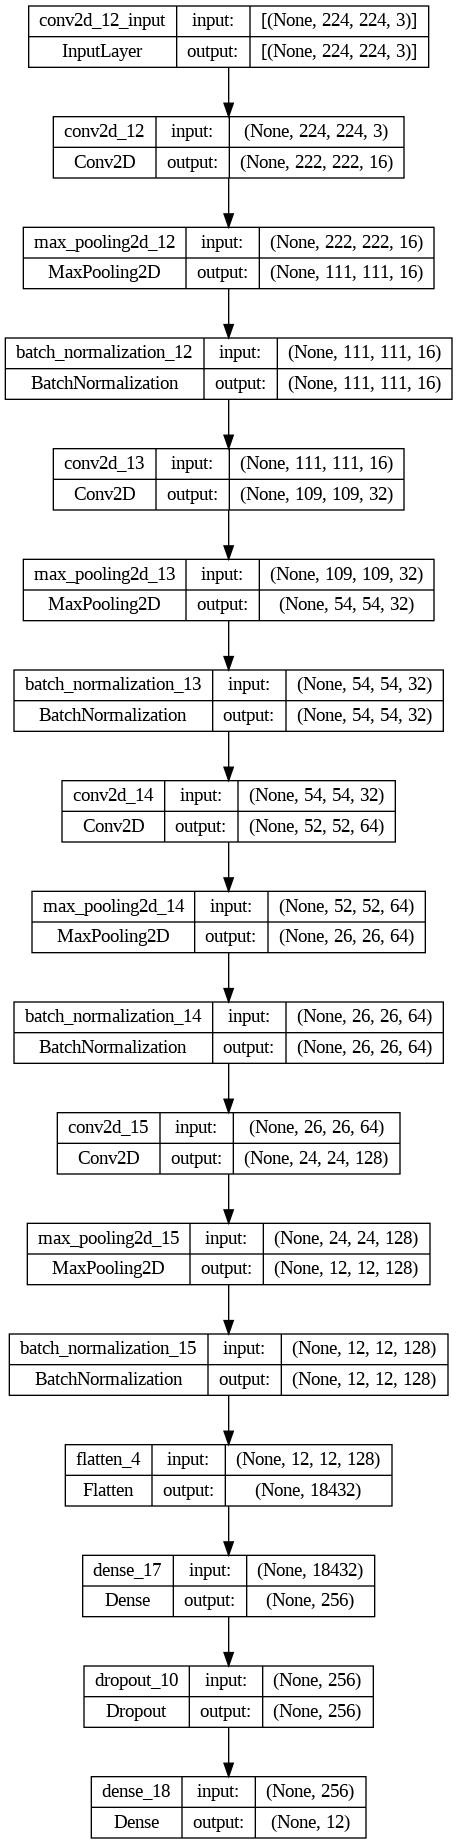

In [ ]:
model_mf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_2_aug'

model_mf.load_weights(model_name)

model_mf.summary()

from tensorflow.keras.utils import plot_model

plot_model(model_mf, show_shapes=True, show_layer_names=True)


##### Run this to get the data for the midle_mf

In [ ]:
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar

import glob
TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(train_files)}):\n\t{train_files}')
#print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
#      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
#print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
 #     f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

--2023-04-16 08:47:14--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2023-04-16 08:47:14--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G   102MB/s    in 24s     

2023-04-16 08:47:38 (84.1 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]

--2023-04-16 08:47:38--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
R

In [ ]:
video_data_path = "video_data/"

mf_train_images, mf_train_labels = middle_frame(train_files, train_labels, video_data_path)
mf_test_images, mf_test_labels = middle_frame(test_files, test_labels, video_data_path)

### Fusion and train the two stream model

In [ ]:
# Separate the data 
of_X_train, of_X_val, of_y_train, of_y_val = train_test_split(of_train_images, of_train_labels_, test_size=0.15, shuffle=False)
mf_X_train, mf_X_val, mf_y_train, mf_y_val = train_test_split(mf_train_images, of_train_labels_, test_size=0.15, shuffle=False)

indices = np.random.permutation(len(of_y_val))
of_y_val = of_y_val[indices]
mf_y_val = mf_y_val[indices]
of_X_val = of_X_val[indices]
mf_X_val = mf_X_val[indices]

indices = np.random.permutation(len(of_y_train))
of_y_train = of_y_train[indices]
mf_y_train = mf_y_train[indices]
of_X_train = of_X_train[indices]
mf_X_train = mf_X_train[indices]

mf_y_val = to_categorical(mf_y_val, num_classes=12)
mf_y_train = to_categorical(mf_y_train, num_classes=12)
of_y_train = to_categorical(of_y_train, num_classes=12)
of_y_val = to_categorical(of_y_val, num_classes=12)

# merge the data
merged_X_train = [mf_X_train, of_X_train]
merged_X_val = [mf_X_val, of_X_val]

#### Maximum

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Maximum()([x, y])

#xy = Dense(128, activation='relu')(xy)
#xy = Dropout(0.5)(xy)
xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)


#xy = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(32, activation='relu')(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(64, activation='relu')(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

plot_model(model_fusion, show_shapes=True, show_layer_names=True)


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_12_input (InputLayer)   [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 222, 222, 16  448         ['conv2d_12_input[0][0]']        
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 111, 111, 16  0          ['conv2d_12[0][0]']              
 )                              )                                                          

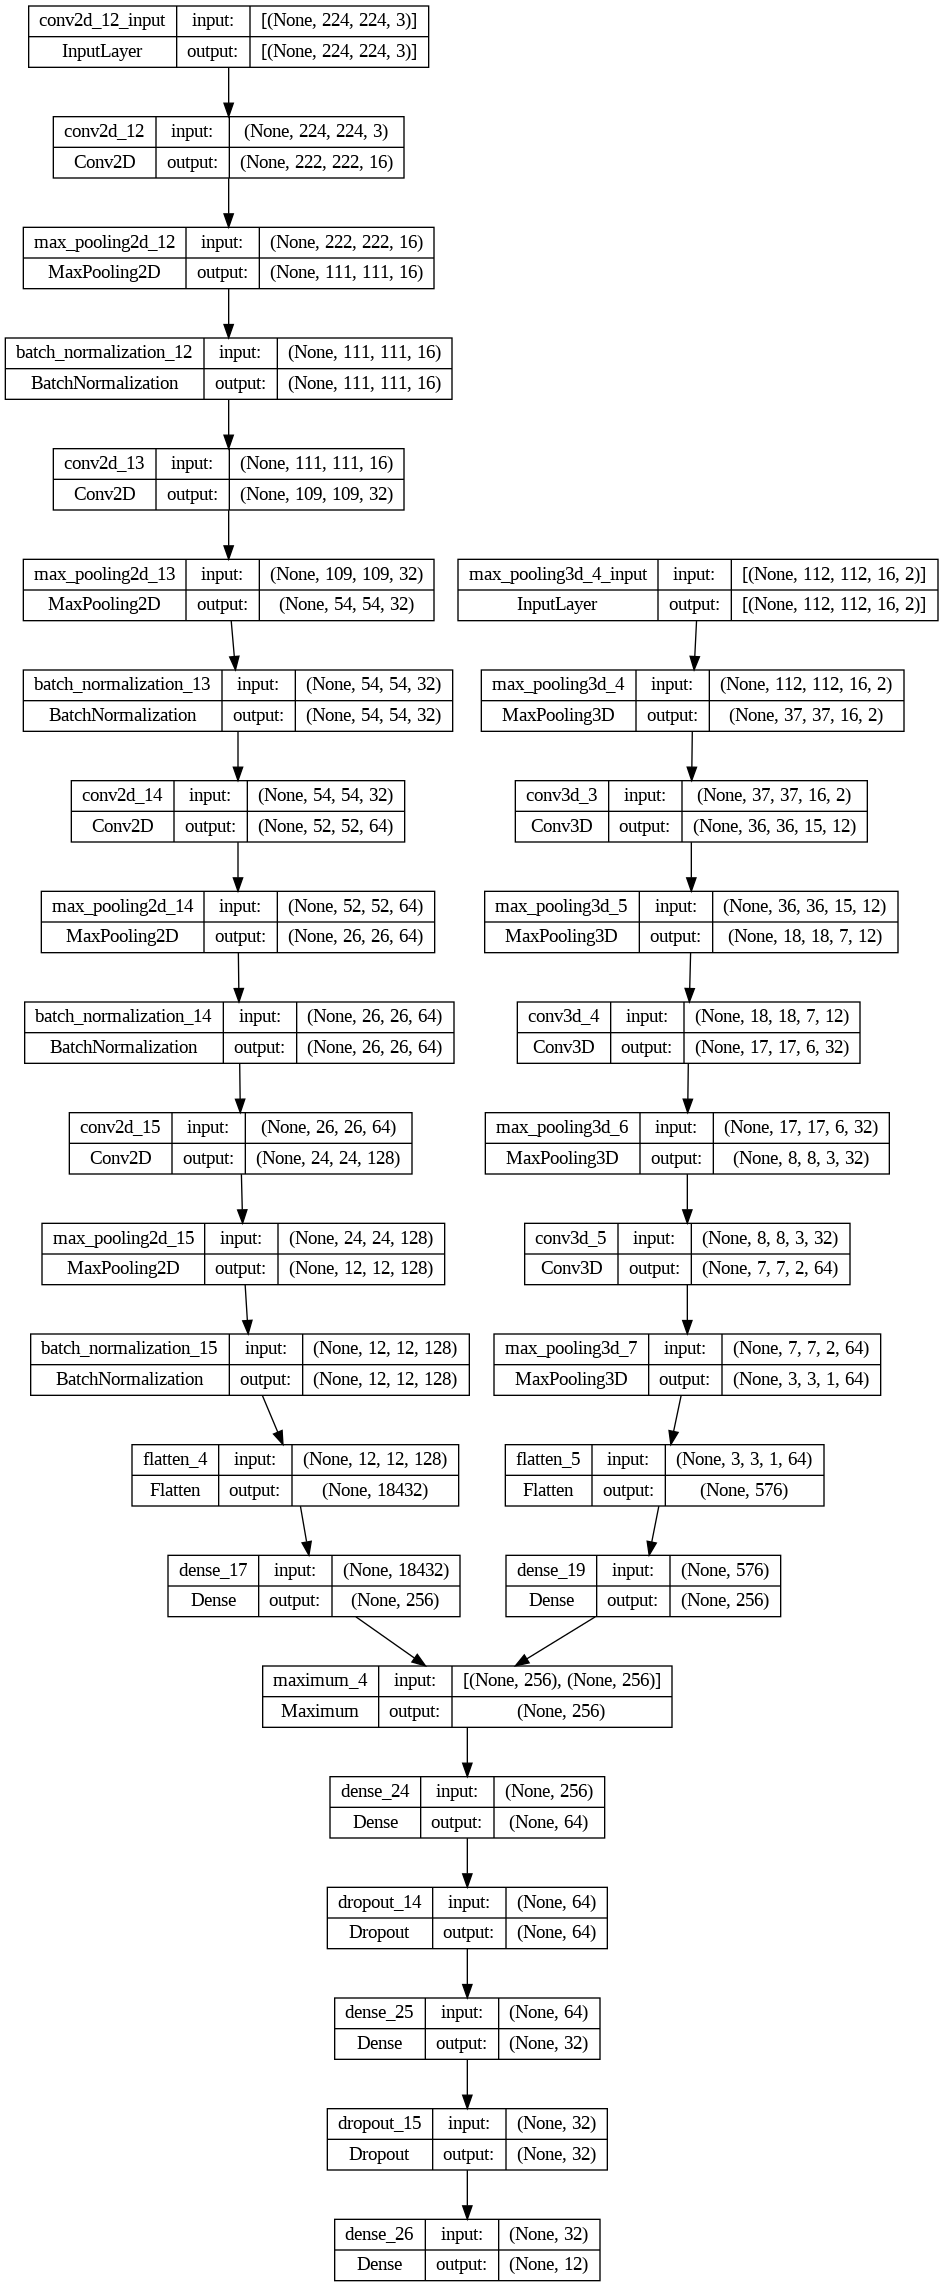

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Maximum()([x, y])

#xy = Dense(128, activation='relu')(xy)
#xy = Dropout(0.5)(xy)
xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)


#xy = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(32, activation='relu')(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(64, activation='relu')(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

opt = Adam()

model_fusion.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #tf.keras.optimizers.Adam()

def step_decay(epoch):
  # step_decay takes an initial learning rate value and drops its value
  initial_lr = 0.01
  drop = 0.3
  epochs_drop = 3
  lr = initial_lr * drop**(epoch//epochs_drop)
  return lr

for layer in model_fusion.layers[:-5]:
    layer.trainable = False

for layer in model_fusion.layers[-5:]:
    layer.trainable = True

model_fusion.summary()
plot_model(model_fusion, show_shapes=True, show_layer_names=True)


Epoch 1/120
23/23 [==============================] - ETA: 0s - loss: 12.5450 - accuracy: 0.0784
Epoch 1: val_accuracy improved from -inf to 0.20635, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 15s 286ms/step - loss: 12.5450 - accuracy: 0.0784 - val_loss: 5.7687 - val_accuracy: 0.2063
Epoch 2/120
22/23 [===========================>..] - ETA: 0s - loss: 8.2950 - accuracy: 0.1321
Epoch 2: val_accuracy did not improve from 0.20635
23/23 [==============================] - 1s 48ms/step - loss: 8.3450 - accuracy: 0.1331 - val_loss: 5.7024 - val_accuracy: 0.1984
Epoch 3/120
22/23 [===========================>..] - ETA: 0s - loss: 6.0774 - accuracy: 0.1790
Epoch 3: val_accuracy did not improve from 0.20635
23/23 [==============================] - 1s 52ms/step - loss: 6.1073 - accuracy: 0.1765 - val_loss: 5.1080 - val_accuracy: 0.1429
Epoch 4/120
21/23 [==========================>...] - ETA: 0s - loss: 6.0191 - accuracy: 0.1741
Epoch 4: val_accuracy did not improve from 0.20635
23/23 [==============================] - 1s 46ms/step - loss: 5.9121 - accuracy: 0.1793 - val_loss: 4.8458 - val_accuracy: 0.1667
Epoch 5/120
23/23 [====================

23/23 [==============================] - 5s 226ms/step - loss: 3.7740 - accuracy: 0.3361 - val_loss: 3.9254 - val_accuracy: 0.2222
Epoch 11/120
22/23 [===========================>..] - ETA: 0s - loss: 3.1646 - accuracy: 0.3963
Epoch 11: val_accuracy did not improve from 0.22222
23/23 [==============================] - 1s 49ms/step - loss: 3.1897 - accuracy: 0.3950 - val_loss: 3.8865 - val_accuracy: 0.2222
Epoch 12/120
22/23 [===========================>..] - ETA: 0s - loss: 3.2969 - accuracy: 0.3722
Epoch 12: val_accuracy did not improve from 0.22222
23/23 [==============================] - 1s 54ms/step - loss: 3.2876 - accuracy: 0.3754 - val_loss: 3.8269 - val_accuracy: 0.2222
Epoch 13/120
23/23 [==============================] - ETA: 0s - loss: 3.0636 - accuracy: 0.3964
Epoch 13: val_accuracy did not improve from 0.22222
23/23 [==============================] - 1s 52ms/step - loss: 3.0636 - accuracy: 0.3964 - val_loss: 3.8430 - val_accuracy: 0.2143
Epoch 14/120
23/23 [===============

23/23 [==============================] - 4s 193ms/step - loss: 3.0080 - accuracy: 0.4258 - val_loss: 3.7908 - val_accuracy: 0.2302
Epoch 15/120
22/23 [===========================>..] - ETA: 0s - loss: 2.9450 - accuracy: 0.4304
Epoch 15: val_accuracy improved from 0.23016 to 0.25397, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 5s 240ms/step - loss: 2.9564 - accuracy: 0.4286 - val_loss: 3.8118 - val_accuracy: 0.2540
Epoch 16/120
23/23 [==============================] - ETA: 0s - loss: 2.8526 - accuracy: 0.4370
Epoch 16: val_accuracy did not improve from 0.25397
23/23 [==============================] - 1s 48ms/step - loss: 2.8526 - accuracy: 0.4370 - val_loss: 3.8139 - val_accuracy: 0.2381
Epoch 17/120
22/23 [===========================>..] - ETA: 0s - loss: 2.8024 - accuracy: 0.4418
Epoch 17: val_accuracy did not improve from 0.25397
23/23 [==============================] - 1s 46ms/step - loss: 2.7997 - accuracy: 0.4412 - val_loss: 3.8970 - val_accuracy: 0.2381
Epoch 18/120
21/23 [==========================>...] - ETA: 0s - loss: 2.6709 - accuracy: 0.4568
Epoch 18: val_accuracy did not improve from 0.25397
23/23 [==============================] - 1s 46ms/step - loss: 2.6554 - accuracy: 0.4594 - val_loss: 3.8912 - val_accuracy: 0.2460
Epoch 19/120
23/23 [===============

23/23 [==============================] - 4s 183ms/step - loss: 2.5723 - accuracy: 0.4692 - val_loss: 3.8373 - val_accuracy: 0.2619
Epoch 20/120
22/23 [===========================>..] - ETA: 0s - loss: 2.5038 - accuracy: 0.5071
Epoch 20: val_accuracy improved from 0.26190 to 0.27778, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 6s 253ms/step - loss: 2.4942 - accuracy: 0.5084 - val_loss: 3.7671 - val_accuracy: 0.2778
Epoch 21/120
22/23 [===========================>..] - ETA: 0s - loss: 2.4722 - accuracy: 0.4759
Epoch 21: val_accuracy improved from 0.27778 to 0.28571, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 4s 182ms/step - loss: 2.4731 - accuracy: 0.4762 - val_loss: 3.8159 - val_accuracy: 0.2857
Epoch 22/120
22/23 [===========================>..] - ETA: 0s - loss: 2.4410 - accuracy: 0.5014
Epoch 22: val_accuracy did not improve from 0.28571
23/23 [==============================] - 1s 53ms/step - loss: 2.4344 - accuracy: 0.5042 - val_loss: 3.8037 - val_accuracy: 0.2857
Epoch 23/120
22/23 [===========================>..] - ETA: 0s - loss: 2.4508 - accuracy: 0.5170
Epoch 23: val_accuracy improved from 0.28571 to 0.29365, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 5s 238ms/step - loss: 2.4441 - accuracy: 0.5196 - val_loss: 3.7312 - val_accuracy: 0.2937
Epoch 24/120
22/23 [===========================>..] - ETA: 0s - loss: 2.3503 - accuracy: 0.5213
Epoch 24: val_accuracy improved from 0.29365 to 0.30159, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 5s 215ms/step - loss: 2.3594 - accuracy: 0.5210 - val_loss: 3.6790 - val_accuracy: 0.3016
Epoch 25/120
23/23 [==============================] - ETA: 0s - loss: 2.2818 - accuracy: 0.5266
Epoch 25: val_accuracy improved from 0.30159 to 0.30952, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 4s 185ms/step - loss: 2.2818 - accuracy: 0.5266 - val_loss: 3.6444 - val_accuracy: 0.3095
Epoch 26/120
22/23 [===========================>..] - ETA: 0s - loss: 2.3017 - accuracy: 0.5312
Epoch 26: val_accuracy did not improve from 0.30952
23/23 [==============================] - 1s 56ms/step - loss: 2.3046 - accuracy: 0.5294 - val_loss: 3.6251 - val_accuracy: 0.3095
Epoch 27/120
22/23 [===========================>..] - ETA: 0s - loss: 2.2118 - accuracy: 0.5511
Epoch 27: val_accuracy did not improve from 0.30952
23/23 [==============================] - 1s 53ms/step - loss: 2.2133 - accuracy: 0.5504 - val_loss: 3.6244 - val_accuracy: 0.3095
Epoch 28/120
22/23 [===========================>..] - ETA: 0s - loss: 2.1303 - accuracy: 0.5724
Epoch 28: val_accuracy improved from 0.30952 to 0.31746, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 5s 237ms/step - loss: 2.1261 - accuracy: 0.5756 - val_loss: 3.6582 - val_accuracy: 0.3175
Epoch 29/120
23/23 [==============================] - ETA: 0s - loss: 2.1629 - accuracy: 0.5504
Epoch 29: val_accuracy improved from 0.31746 to 0.34127, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 4s 182ms/step - loss: 2.1629 - accuracy: 0.5504 - val_loss: 3.6184 - val_accuracy: 0.3413
Epoch 30/120
22/23 [===========================>..] - ETA: 0s - loss: 2.1002 - accuracy: 0.5810
Epoch 30: val_accuracy improved from 0.34127 to 0.35714, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 4s 201ms/step - loss: 2.0874 - accuracy: 0.5868 - val_loss: 3.7154 - val_accuracy: 0.3571
Epoch 31/120
22/23 [===========================>..] - ETA: 0s - loss: 2.0684 - accuracy: 0.5881
Epoch 31: val_accuracy improved from 0.35714 to 0.36508, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum_Adam


23/23 [==============================] - 5s 233ms/step - loss: 2.0794 - accuracy: 0.5896 - val_loss: 3.6995 - val_accuracy: 0.3651
Epoch 32/120
21/23 [==========================>...] - ETA: 0s - loss: 1.9938 - accuracy: 0.6042
Epoch 32: val_accuracy did not improve from 0.36508
23/23 [==============================] - 1s 53ms/step - loss: 2.0086 - accuracy: 0.5980 - val_loss: 3.7022 - val_accuracy: 0.3651
Epoch 33/120
22/23 [===========================>..] - ETA: 0s - loss: 2.0216 - accuracy: 0.5923
Epoch 33: val_accuracy did not improve from 0.36508
23/23 [==============================] - 1s 46ms/step - loss: 2.0225 - accuracy: 0.5924 - val_loss: 3.8553 - val_accuracy: 0.3571
Epoch 34/120
22/23 [===========================>..] - ETA: 0s - loss: 2.0025 - accuracy: 0.5980
Epoch 34: val_accuracy did not improve from 0.36508
23/23 [==============================] - 1s 45ms/step - loss: 2.0008 - accuracy: 0.5966 - val_loss: 3.8874 - val_accuracy: 0.3571
Epoch 35/120
22/23 [===============

23/23 [==============================] - 5s 221ms/step - loss: 1.8412 - accuracy: 0.6218 - val_loss: 3.8533 - val_accuracy: 0.3730
Epoch 40/120
22/23 [===========================>..] - ETA: 0s - loss: 1.8726 - accuracy: 0.6193
Epoch 40: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 53ms/step - loss: 1.8739 - accuracy: 0.6190 - val_loss: 4.0309 - val_accuracy: 0.3730
Epoch 41/120
23/23 [==============================] - ETA: 0s - loss: 1.8735 - accuracy: 0.6148
Epoch 41: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 53ms/step - loss: 1.8735 - accuracy: 0.6148 - val_loss: 4.1771 - val_accuracy: 0.3730
Epoch 42/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7184 - accuracy: 0.6733
Epoch 42: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 47ms/step - loss: 1.7156 - accuracy: 0.6737 - val_loss: 4.1596 - val_accuracy: 0.3730
Epoch 43/120
22/23 [===============

23/23 [==============================] - 4s 198ms/step - loss: 1.7336 - accuracy: 0.6303 - val_loss: 4.1221 - val_accuracy: 0.3810
Epoch 44/120
22/23 [===========================>..] - ETA: 0s - loss: 1.6654 - accuracy: 0.6719
Epoch 44: val_accuracy did not improve from 0.38095
23/23 [==============================] - 2s 68ms/step - loss: 1.6571 - accuracy: 0.6751 - val_loss: 4.2413 - val_accuracy: 0.3730
Epoch 45/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7121 - accuracy: 0.6506
Epoch 45: val_accuracy did not improve from 0.38095
23/23 [==============================] - 2s 73ms/step - loss: 1.7100 - accuracy: 0.6499 - val_loss: 4.3326 - val_accuracy: 0.3730
Epoch 46/120
23/23 [==============================] - ETA: 0s - loss: 1.7582 - accuracy: 0.6331
Epoch 46: val_accuracy did not improve from 0.38095
23/23 [==============================] - 1s 56ms/step - loss: 1.7582 - accuracy: 0.6331 - val_loss: 4.3509 - val_accuracy: 0.3730
Epoch 47/120
23/23 [===============

23/23 [==============================] - 5s 234ms/step - loss: 1.5354 - accuracy: 0.6891 - val_loss: 4.5479 - val_accuracy: 0.3968
Epoch 55/120
22/23 [===========================>..] - ETA: 0s - loss: 1.4894 - accuracy: 0.7003
Epoch 55: val_accuracy did not improve from 0.39683
23/23 [==============================] - 1s 55ms/step - loss: 1.4956 - accuracy: 0.6989 - val_loss: 4.5698 - val_accuracy: 0.3968
Epoch 56/120
23/23 [==============================] - ETA: 0s - loss: 1.4997 - accuracy: 0.7073
Epoch 56: val_accuracy did not improve from 0.39683
23/23 [==============================] - 1s 55ms/step - loss: 1.4997 - accuracy: 0.7073 - val_loss: 4.4961 - val_accuracy: 0.3968
Epoch 57/120
22/23 [===========================>..] - ETA: 0s - loss: 1.4462 - accuracy: 0.7116
Epoch 57: val_accuracy did not improve from 0.39683
23/23 [==============================] - 1s 55ms/step - loss: 1.4502 - accuracy: 0.7087 - val_loss: 4.5568 - val_accuracy: 0.3968
Epoch 58/120
21/23 [===============

23/23 [==============================] - 5s 239ms/step - loss: 1.0463 - accuracy: 0.7871 - val_loss: 6.3209 - val_accuracy: 0.4048
Epoch 98/120
21/23 [==========================>...] - ETA: 0s - loss: 1.0267 - accuracy: 0.7976
Epoch 98: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 46ms/step - loss: 1.0268 - accuracy: 0.7969 - val_loss: 6.3806 - val_accuracy: 0.3968
Epoch 99/120
22/23 [===========================>..] - ETA: 0s - loss: 1.0390 - accuracy: 0.7884
Epoch 99: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 54ms/step - loss: 1.0425 - accuracy: 0.7885 - val_loss: 6.3337 - val_accuracy: 0.3968
Epoch 100/120
23/23 [==============================] - ETA: 0s - loss: 1.0146 - accuracy: 0.8025
Epoch 100: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 47ms/step - loss: 1.0146 - accuracy: 0.8025 - val_loss: 6.2573 - val_accuracy: 0.3968
Epoch 101/120
21/23 [============

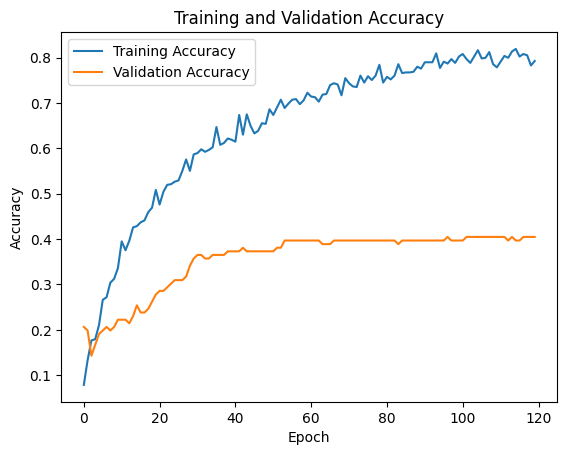

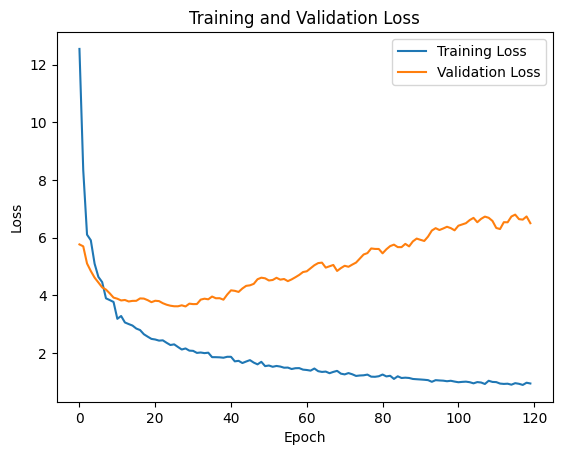

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Maximum()([x, y])

#xy = Dense(128, activation='relu')(xy)
#xy = Dropout(0.5)(xy)
xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)


#xy = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(32, activation='relu')(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(64, activation='relu')(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

opt = Adam()

model_fusion.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #tf.keras.optimizers.Adam()

def step_decay(epoch):
  # step_decay takes an initial learning rate value and drops its value
  initial_lr = 0.01
  drop = 0.3
  epochs_drop = 3
  lr = initial_lr * drop**(epoch//epochs_drop)
  return lr

for layer in model_fusion.layers[:-5]:
    layer.trainable = False

for layer in model_fusion.layers[-5:]:
    layer.trainable = True

step_size= 6

def cyclical_learning_rate(epoch, step_size):
    base_lr = 1e-4
    max_lr = 1e-2
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return new_lr

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/' + 'model_4_maximum_Adam'

# define a checkpoint to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = LearningRateScheduler(lambda epoch: cyclical_learning_rate(epoch, step_size))
#lr_scheduler = LearningRateScheduler(step_decay)

# train the final model on the merged input data
history = model_fusion.fit([mf_X_train, of_X_train], of_y_train, validation_data=([mf_X_val, of_X_val], of_y_val), epochs=120, shuffle=True, callbacks = [checkpoint])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



##### Test evaluation

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Maximum()([x, y])

xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

model_fusion.count_params()

In [ ]:
indices = np.random.permutation(len(of_test_labels_))
of_test_labels_ = of_test_labels_[indices]
mf_test_images = mf_test_images[indices]
of_test_images = of_test_images[indices]
mf_test_labels = mf_test_labels[indices]

of_test_labels = to_categorical(of_test_labels_, num_classes=12)

In [ ]:
model_fusion.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 

# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_maximum'
model_fusion.load_weights(model_name)

test_loss, test_accuracy = model_fusion.evaluate([mf_test_images, of_test_images], of_test_labels, batch_size=64)
print('Test accuracy Model Fusion Maximum:', test_accuracy)

#### Average

Epoch 1/120
23/23 [==============================] - ETA: 0s - loss: 8.8749 - accuracy: 0.0910
Epoch 1: val_accuracy improved from -inf to 0.00794, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 6s 225ms/step - loss: 8.8749 - accuracy: 0.0910 - val_loss: 7.9798 - val_accuracy: 0.0079 - lr: 1.0000e-04
Epoch 2/120
23/23 [==============================] - ETA: 0s - loss: 6.8714 - accuracy: 0.1134
Epoch 2: val_accuracy improved from 0.00794 to 0.01587, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 6s 254ms/step - loss: 6.8714 - accuracy: 0.1134 - val_loss: 4.9004 - val_accuracy: 0.0159 - lr: 0.0018
Epoch 3/120
22/23 [===========================>..] - ETA: 0s - loss: 4.3143 - accuracy: 0.2060
Epoch 3: val_accuracy improved from 0.01587 to 0.09524, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 4s 198ms/step - loss: 4.3023 - accuracy: 0.2045 - val_loss: 4.1497 - val_accuracy: 0.0952 - lr: 0.0034
Epoch 4/120
22/23 [===========================>..] - ETA: 0s - loss: 3.2981 - accuracy: 0.3381
Epoch 4: val_accuracy improved from 0.09524 to 0.15873, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 216ms/step - loss: 3.2962 - accuracy: 0.3375 - val_loss: 3.7802 - val_accuracy: 0.1587 - lr: 0.0050
Epoch 5/120
23/23 [==============================] - ETA: 0s - loss: 2.8410 - accuracy: 0.4090
Epoch 5: val_accuracy improved from 0.15873 to 0.26984, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 235ms/step - loss: 2.8410 - accuracy: 0.4090 - val_loss: 3.4597 - val_accuracy: 0.2698 - lr: 0.0067
Epoch 6/120
23/23 [==============================] - ETA: 0s - loss: 2.4770 - accuracy: 0.4888
Epoch 6: val_accuracy improved from 0.26984 to 0.36508, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 215ms/step - loss: 2.4770 - accuracy: 0.4888 - val_loss: 3.3742 - val_accuracy: 0.3651 - lr: 0.0083
Epoch 7/120
22/23 [===========================>..] - ETA: 0s - loss: 2.2103 - accuracy: 0.5582
Epoch 7: val_accuracy did not improve from 0.36508
23/23 [==============================] - 1s 56ms/step - loss: 2.2098 - accuracy: 0.5588 - val_loss: 3.4939 - val_accuracy: 0.3651 - lr: 0.0100
Epoch 8/120
22/23 [===========================>..] - ETA: 0s - loss: 2.1370 - accuracy: 0.5852
Epoch 8: val_accuracy did not improve from 0.36508
23/23 [==============================] - 1s 57ms/step - loss: 2.1280 - accuracy: 0.5896 - val_loss: 3.8580 - val_accuracy: 0.3651 - lr: 0.0083
Epoch 9/120
22/23 [===========================>..] - ETA: 0s - loss: 2.0089 - accuracy: 0.6364
Epoch 9: val_accuracy improved from 0.36508 to 0.37302, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 236ms/step - loss: 2.0136 - accuracy: 0.6345 - val_loss: 3.7409 - val_accuracy: 0.3730 - lr: 0.0067
Epoch 10/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7951 - accuracy: 0.6619
Epoch 10: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 51ms/step - loss: 1.7935 - accuracy: 0.6611 - val_loss: 4.0153 - val_accuracy: 0.3730 - lr: 0.0050
Epoch 11/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7170 - accuracy: 0.6761
Epoch 11: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 52ms/step - loss: 1.7206 - accuracy: 0.6765 - val_loss: 4.1964 - val_accuracy: 0.3730 - lr: 0.0034
Epoch 12/120
22/23 [===========================>..] - ETA: 0s - loss: 1.6830 - accuracy: 0.6719
Epoch 12: val_accuracy did not improve from 0.37302
23/23 [==============================] - 1s 58ms/step - loss: 1.6811 - accuracy: 0.6723 - val_loss: 4.3729 - val_accuracy: 0.3

23/23 [==============================] - 6s 249ms/step - loss: 1.5939 - accuracy: 0.6863 - val_loss: 4.4237 - val_accuracy: 0.3810 - lr: 0.0034
Epoch 16/120
22/23 [===========================>..] - ETA: 0s - loss: 1.5218 - accuracy: 0.7017
Epoch 16: val_accuracy did not improve from 0.38095
23/23 [==============================] - 1s 58ms/step - loss: 1.5197 - accuracy: 0.7031 - val_loss: 4.3930 - val_accuracy: 0.3730 - lr: 0.0050
Epoch 17/120
21/23 [==========================>...] - ETA: 0s - loss: 1.4919 - accuracy: 0.7054
Epoch 17: val_accuracy did not improve from 0.38095
23/23 [==============================] - 1s 57ms/step - loss: 1.4800 - accuracy: 0.7115 - val_loss: 4.5726 - val_accuracy: 0.3730 - lr: 0.0067
Epoch 18/120
23/23 [==============================] - ETA: 0s - loss: 1.4697 - accuracy: 0.6989
Epoch 18: val_accuracy improved from 0.38095 to 0.39683, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 210ms/step - loss: 1.4697 - accuracy: 0.6989 - val_loss: 4.7177 - val_accuracy: 0.3968 - lr: 0.0083
Epoch 19/120
22/23 [===========================>..] - ETA: 0s - loss: 1.5199 - accuracy: 0.7017
Epoch 19: val_accuracy improved from 0.39683 to 0.40476, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 246ms/step - loss: 1.5157 - accuracy: 0.7017 - val_loss: 4.9192 - val_accuracy: 0.4048 - lr: 0.0100
Epoch 20/120
21/23 [==========================>...] - ETA: 0s - loss: 1.3841 - accuracy: 0.7411
Epoch 20: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 57ms/step - loss: 1.3816 - accuracy: 0.7451 - val_loss: 5.1231 - val_accuracy: 0.4048 - lr: 0.0083
Epoch 21/120
22/23 [===========================>..] - ETA: 0s - loss: 1.4401 - accuracy: 0.7273
Epoch 21: val_accuracy improved from 0.40476 to 0.41270, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average


23/23 [==============================] - 5s 213ms/step - loss: 1.4392 - accuracy: 0.7241 - val_loss: 4.6438 - val_accuracy: 0.4127 - lr: 0.0067
Epoch 22/120
23/23 [==============================] - ETA: 0s - loss: 1.3560 - accuracy: 0.7255
Epoch 22: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 58ms/step - loss: 1.3560 - accuracy: 0.7255 - val_loss: 4.4362 - val_accuracy: 0.4048 - lr: 0.0050
Epoch 23/120
23/23 [==============================] - ETA: 0s - loss: 1.2490 - accuracy: 0.7563
Epoch 23: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 57ms/step - loss: 1.2490 - accuracy: 0.7563 - val_loss: 4.7764 - val_accuracy: 0.3968 - lr: 0.0034
Epoch 24/120
22/23 [===========================>..] - ETA: 0s - loss: 1.2263 - accuracy: 0.7514
Epoch 24: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 59ms/step - loss: 1.2328 - accuracy: 0.7507 - val_loss: 4.8729 - val_accuracy: 0.3

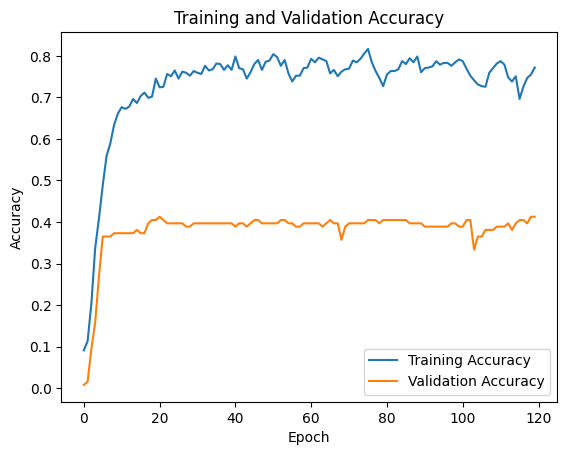

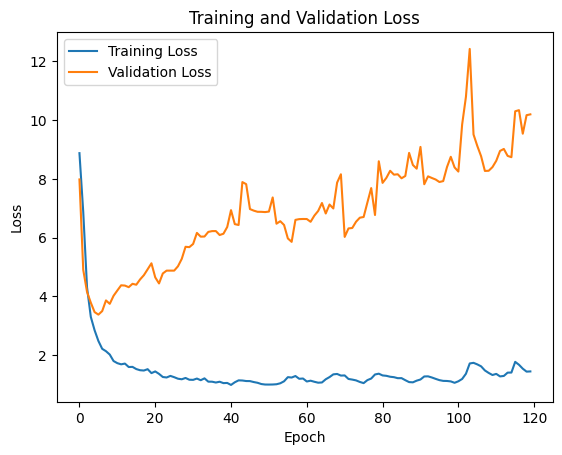

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Average()([x, y])

#xy = Dense(128, activation='relu')(xy)
#xy = Dropout(0.5)(xy)
xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)


#xy = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(32, activation='relu')(xy)
#xy = Dropout(0.5)(xy)

#xy = Dense(64, activation='relu')(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

opt = Adam()

model_fusion.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #tf.keras.optimizers.Adam()

def step_decay(epoch):
  # step_decay takes an initial learning rate value and drops its value
  initial_lr = 0.01
  drop = 0.3
  epochs_drop = 3
  lr = initial_lr * drop**(epoch//epochs_drop)
  return lr

for layer in model_fusion.layers[:-5]:
    layer.trainable = False

for layer in model_fusion.layers[-5:]:
    layer.trainable = True

step_size= 6

def cyclical_learning_rate(epoch, step_size):
    base_lr = 1e-4
    max_lr = 1e-2
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return new_lr

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/' + 'model_4_average'

# define a checkpoint to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = LearningRateScheduler(lambda epoch: cyclical_learning_rate(epoch, step_size))
#lr_scheduler = LearningRateScheduler(step_decay)

# train the final model on the merged input data
history = model_fusion.fit([mf_X_train, of_X_train], of_y_train, validation_data=([mf_X_val, of_X_val], of_y_val), epochs=120, shuffle=True, callbacks = [lr_scheduler, checkpoint])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



##### Test evaluation

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Average()([x, y])

xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)
model_fusion.count_params()

5003640

In [ ]:
model_fusion.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 

# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_average'
model_fusion.load_weights(model_name)

test_loss, test_accuracy = model_fusion.evaluate([mf_test_images, of_test_images], of_test_labels, batch_size=64)
print('Test accuracy Model Fusion Average:', test_accuracy)

6/6 [==============================] - 2s 80ms/step - loss: 3.2441 - accuracy: 0.3222
Test accuracy Model Fusion Average: 0.3222222328186035


#### Concatenate

Epoch 1/120
23/23 [==============================] - ETA: 0s - loss: 9.0604 - accuracy: 0.0812
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 7s 241ms/step - loss: 9.0604 - accuracy: 0.0812 - val_loss: 8.3480 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/120
22/23 [===========================>..] - ETA: 0s - loss: 7.2415 - accuracy: 0.1236
Epoch 2: val_accuracy improved from 0.00000 to 0.02381, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 5s 219ms/step - loss: 7.2020 - accuracy: 0.1289 - val_loss: 5.6008 - val_accuracy: 0.0238 - lr: 0.0018
Epoch 3/120
23/23 [==============================] - ETA: 0s - loss: 4.0941 - accuracy: 0.2605
Epoch 3: val_accuracy did not improve from 0.02381
23/23 [==============================] - 1s 59ms/step - loss: 4.0941 - accuracy: 0.2605 - val_loss: 5.1027 - val_accuracy: 0.0079 - lr: 0.0034
Epoch 4/120
23/23 [==============================] - ETA: 0s - loss: 3.2467 - accuracy: 0.3880
Epoch 4: val_accuracy did not improve from 0.02381
23/23 [==============================] - 2s 75ms/step - loss: 3.2467 - accuracy: 0.3880 - val_loss: 4.3016 - val_accuracy: 0.0000e+00 - lr: 0.0050
Epoch 5/120
22/23 [===========================>..] - ETA: 0s - loss: 2.7167 - accuracy: 0.4659
Epoch 5: val_accuracy did not improve from 0.02381
23/23 [==============================] - 2s 73ms/step - loss: 2.7364 - accuracy: 0.4650 - val_loss: 4.1464 - val_accuracy: 0.007

23/23 [==============================] - 5s 203ms/step - loss: 2.5893 - accuracy: 0.4804 - val_loss: 3.6733 - val_accuracy: 0.2063 - lr: 0.0083
Epoch 7/120
22/23 [===========================>..] - ETA: 0s - loss: 2.2963 - accuracy: 0.5384
Epoch 7: val_accuracy improved from 0.20635 to 0.26190, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 5s 208ms/step - loss: 2.2911 - accuracy: 0.5392 - val_loss: 3.5096 - val_accuracy: 0.2619 - lr: 0.0100
Epoch 8/120
22/23 [===========================>..] - ETA: 0s - loss: 2.1978 - accuracy: 0.5554
Epoch 8: val_accuracy improved from 0.26190 to 0.35714, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 5s 236ms/step - loss: 2.1994 - accuracy: 0.5546 - val_loss: 3.3990 - val_accuracy: 0.3571 - lr: 0.0083
Epoch 9/120
23/23 [==============================] - ETA: 0s - loss: 1.9985 - accuracy: 0.5896
Epoch 9: val_accuracy did not improve from 0.35714
23/23 [==============================] - 1s 58ms/step - loss: 1.9985 - accuracy: 0.5896 - val_loss: 3.7760 - val_accuracy: 0.3095 - lr: 0.0067
Epoch 10/120
22/23 [===========================>..] - ETA: 0s - loss: 1.8670 - accuracy: 0.6435
Epoch 10: val_accuracy improved from 0.35714 to 0.36508, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 5s 211ms/step - loss: 1.8669 - accuracy: 0.6415 - val_loss: 4.0426 - val_accuracy: 0.3651 - lr: 0.0050
Epoch 11/120
21/23 [==========================>...] - ETA: 0s - loss: 1.8243 - accuracy: 0.6577
Epoch 11: val_accuracy improved from 0.36508 to 0.38889, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 6s 260ms/step - loss: 1.8312 - accuracy: 0.6569 - val_loss: 3.7763 - val_accuracy: 0.3889 - lr: 0.0034
Epoch 12/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7827 - accuracy: 0.6932
Epoch 12: val_accuracy did not improve from 0.38889
23/23 [==============================] - 1s 50ms/step - loss: 1.7779 - accuracy: 0.6933 - val_loss: 3.8377 - val_accuracy: 0.3889 - lr: 0.0018
Epoch 13/120
22/23 [===========================>..] - ETA: 0s - loss: 1.6625 - accuracy: 0.6861
Epoch 13: val_accuracy did not improve from 0.38889
23/23 [==============================] - 1s 56ms/step - loss: 1.6608 - accuracy: 0.6863 - val_loss: 3.8386 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 14/120
22/23 [===========================>..] - ETA: 0s - loss: 1.7671 - accuracy: 0.6747
Epoch 14: val_accuracy did not improve from 0.38889
23/23 [==============================] - 1s 56ms/step - loss: 1.7683 - accuracy: 0.6737 - val_loss: 3.8334 - val_accuracy:

23/23 [==============================] - 4s 195ms/step - loss: 1.6225 - accuracy: 0.7003 - val_loss: 3.8509 - val_accuracy: 0.3968 - lr: 0.0034
Epoch 16/120
22/23 [===========================>..] - ETA: 0s - loss: 1.5503 - accuracy: 0.6974
Epoch 16: val_accuracy improved from 0.39683 to 0.40476, saving model to /content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate


23/23 [==============================] - 6s 259ms/step - loss: 1.5437 - accuracy: 0.7017 - val_loss: 4.5203 - val_accuracy: 0.4048 - lr: 0.0050
Epoch 17/120
23/23 [==============================] - ETA: 0s - loss: 1.5793 - accuracy: 0.6919
Epoch 17: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 57ms/step - loss: 1.5793 - accuracy: 0.6919 - val_loss: 5.6889 - val_accuracy: 0.4048 - lr: 0.0067
Epoch 18/120
22/23 [===========================>..] - ETA: 0s - loss: 1.6346 - accuracy: 0.7060
Epoch 18: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 56ms/step - loss: 1.6340 - accuracy: 0.7059 - val_loss: 5.2541 - val_accuracy: 0.3889 - lr: 0.0083
Epoch 19/120
22/23 [===========================>..] - ETA: 0s - loss: 1.6995 - accuracy: 0.6989
Epoch 19: val_accuracy did not improve from 0.40476
23/23 [==============================] - 1s 50ms/step - loss: 1.6956 - accuracy: 0.7003 - val_loss: 4.9491 - val_accuracy: 0.3

23/23 [==============================] - 5s 237ms/step - loss: 1.3855 - accuracy: 0.7605 - val_loss: 8.7636 - val_accuracy: 0.4127 - lr: 0.0050
Epoch 35/120
22/23 [===========================>..] - ETA: 0s - loss: 1.4282 - accuracy: 0.7457
Epoch 35: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 57ms/step - loss: 1.4252 - accuracy: 0.7465 - val_loss: 8.5502 - val_accuracy: 0.3968 - lr: 0.0034
Epoch 36/120
23/23 [==============================] - ETA: 0s - loss: 1.3120 - accuracy: 0.7703
Epoch 36: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 50ms/step - loss: 1.3120 - accuracy: 0.7703 - val_loss: 9.1971 - val_accuracy: 0.4048 - lr: 0.0018
Epoch 37/120
23/23 [==============================] - ETA: 0s - loss: 1.2493 - accuracy: 0.7941
Epoch 37: val_accuracy did not improve from 0.41270
23/23 [==============================] - 1s 51ms/step - loss: 1.2493 - accuracy: 0.7941 - val_loss: 9.2085 - val_accuracy: 0.4

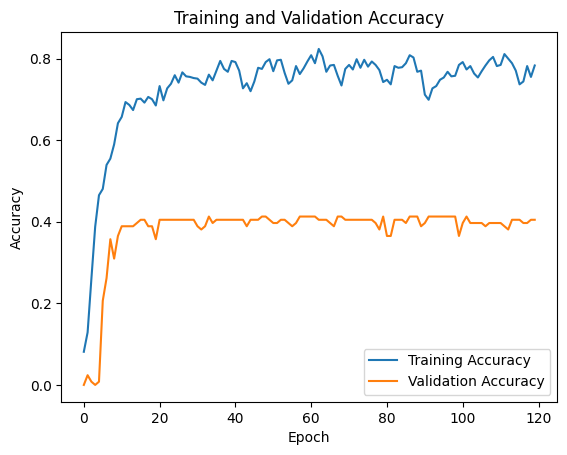

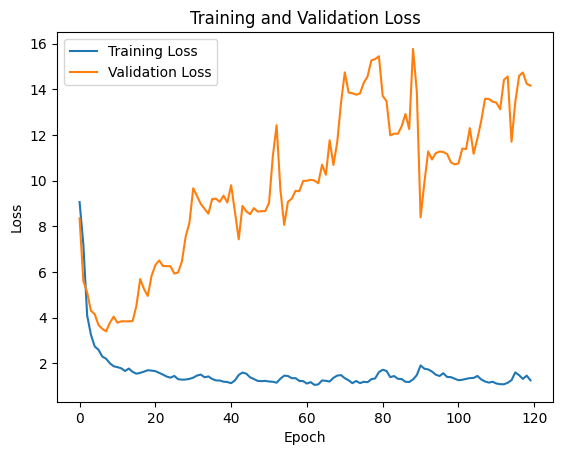

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Concatenate(axis=1)([x, y])

#xy = Dense(128, activation='relu')(xy)
#xy = Dropout(0.5)(xy)
xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)#, kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

opt = Adam()

model_fusion.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #tf.keras.optimizers.Adam()

for layer in model_fusion.layers[:-5]:
    layer.trainable = False

for layer in model_fusion.layers[-5:]:
    layer.trainable = True

step_size= 6

def cyclical_learning_rate(epoch, step_size):
    base_lr = 1e-4
    max_lr = 1e-2
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return new_lr

model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/' + 'model_4_concatinate'

# define a checkpoint to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = LearningRateScheduler(lambda epoch: cyclical_learning_rate(epoch, step_size))
#lr_scheduler = LearningRateScheduler(step_decay)

# train the final model on the merged input data
history = model_fusion.fit([mf_X_train, of_X_train], of_y_train, validation_data=([mf_X_val, of_X_val], of_y_val), epochs=120, shuffle=True, callbacks = [lr_scheduler, checkpoint])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



##### Test evaluation

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

for layer in model_mf.layers[:]:
    layer.trainable = False
for layer in model_of.layers[:]:
    layer.trainable = False

x = model_mf.layers[-3].output
new_output = Model(inputs=model_mf.input, outputs=x)

y = model_of.layers[-3].output
new_output_of = Model(inputs=model_of.input, outputs=y)

xy = tf.keras.layers.Concatenate(axis=1)([x, y])

xy = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)
xy = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(xy)
xy = Dropout(0.5)(xy)

outputs = Dense(12, activation='softmax')(xy)

model_fusion = tf.keras.Model([model_mf.input, model_of.input], outputs)

In [ ]:
model_fusion.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 

# load weights for best validation performance at 0.41606
model_name = '/content/drive/My Drive/Computer_Vision_2/Assignment_5/model_4_concatinate'
model_fusion.load_weights(model_name)

test_loss, test_accuracy = model_fusion.evaluate([mf_test_images, of_test_images], of_test_labels, batch_size=64)
print('Test accuracy Model Fusion Concatinate:', test_accuracy)

6/6 [==============================] - 1s 68ms/step - loss: 3.3840 - accuracy: 0.3139
Test accuracy Model Fusion Concatenate: 0.31388887763023376
